## Import useful stuff and define ancillary functions

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from __future__ import division

from collections import defaultdict, namedtuple
import os
import re
import sys

import numpy as np
import pandas as pd
import cPickle as pickle
from scipy import sparse
import seaborn as sn
import sklearn as sl


def hist_columns(df, index, cycles, step, init=0, subplots=2, legend=False, alpha=0.2, bins=10, stacked=False):
    for i in range(init, init+cycles*step*subplots, step*subplots):
        fig, axes = plt.subplots(1, subplots, figsize=(18, 3))
        for j in range(subplots):
            init = i+j*step
            end = i+(j+1)*step
            mask = index[init:end]
            tmp = df[mask].dropna(axis=1, how='all')
            if tmp.sizezeze > 0:
                ax = axes[j]
                tmp.plot(kind='hist', alpha=alpha, legend=legend, ax=ax, bins=bins, stacked=stacked, rot=55)
                if legend:
                    lines, labels = ax.get_legend_handles_labels()
                    ax.legend(lines, ['%s (index=%d)'%(l, k) for k, l in enumerate(labels, init)], loc='best')


Populating the interactive namespace from numpy and matplotlib


# Load train data
Using pandas' read_csv with all the defaults

In [15]:
if os.name == 'nt':
    TRAIN_PATH = r'D:\train.csv'
    PTRAIN_PATH = r'D:\train_preprocessed_float.csv'
    TEST_PATH = r'D:\test.csv'
    GOOGNEWS_PATH = r'D:\GoogleNews-vectors-negative300.bin.gz'
    VOCAB_PATH = r'D:\big.txt'
else:
    TRAIN_PATH = r'/media/mtambos/speedy/train.csv'
    PTRAIN_PATH = r'/media/mtambos/speedy/train_preprocessed_float.csv'
    TEST_PATH = r'/media/mtambos/speedy/test.csv'
    GOOGNEWS_PATH = r'/media/mtambos/speedy/GoogleNews-vectors-negative300.bin.gz'
    VOCAB_PATH = r'/media/mtambos/speedy/big.txt'
#df_orig = pd.read_csv(TRAIN_PATH, index_col="ID")
df = pd.read_csv(PTRAIN_PATH, index_col="ID")
with open('X.pickle', 'rb') as fp:
    X = pickle.load(fp)
#df

### Define columns

In [3]:
other_cols = ['VAR_0073', 'VAR_0075', 'VAR_0156',
              'VAR_0157', 'VAR_0158', 'VAR_0159',
              'VAR_0166', 'VAR_0167', 'VAR_0168',
              'VAR_0169', 'VAR_0176', 'VAR_0177',
              'VAR_0178', 'VAR_0179', 'VAR_0204',
              'VAR_0217', 'VAR_0001', 'VAR_0005',
              'VAR_0044', 'VAR_0200', 'VAR_0202',
              'VAR_0214', 'VAR_0216', 'VAR_0222',
              'VAR_0237', 'VAR_0274', 'VAR_0283',
              'VAR_0305', 'VAR_0325', 'VAR_0342',
              'VAR_0352', 'VAR_0353', 'VAR_0354',
              'VAR_0404', 'VAR_0466', 'VAR_0467',
              'VAR_0493', 'VAR_1934', 'VAR_0008',
              'VAR_0009', 'VAR_0010', 'VAR_0011',
              'VAR_0012', 'VAR_0043', 'VAR_0196',
              'VAR_0226', 'VAR_0229', 'VAR_0230',
              'VAR_0232', 'VAR_0236', 'VAR_0239']
try: 
    # Columns VAR_0218 and VAR_0240 are missing in the training data
    float_cols = ['VAR_%04d'%i for i in range(1, 1935) if ('VAR_%04d'%i) not in other_cols and i not in (218, 240)]
    float_cols = [c for c in float_cols if c in df.columns]
except NameError:
    pass
try:
    float_cols = df.columns[df.dtypes==np.float].tolist()
except NameError:
    pass

In [4]:
df = df_orig

## Analyze columns with suspiciously high standard deviation

Sort columns by their standard deviation w/o NaNs

In [5]:
X = df[float_cols].std(skipna=True)
X.sort(ascending=False)

Plot histograms of the colums. To get an overview, each plot contains 100 columns.

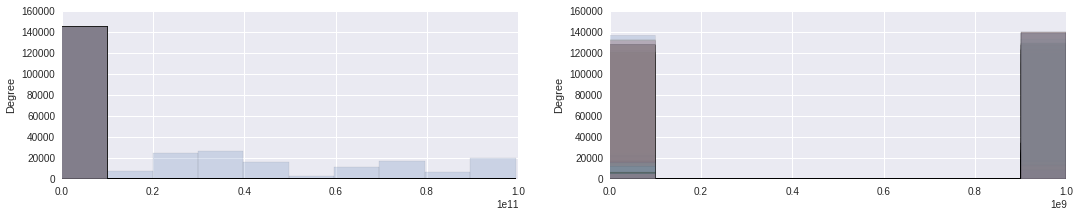

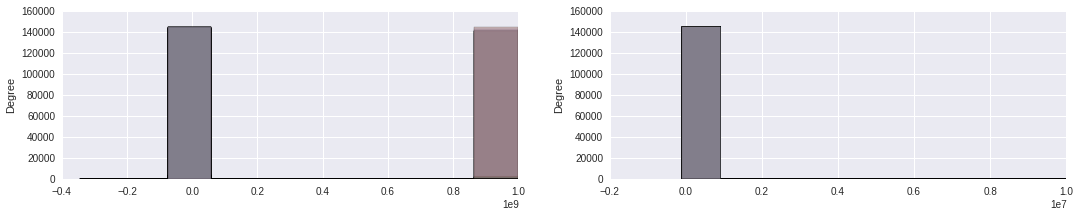

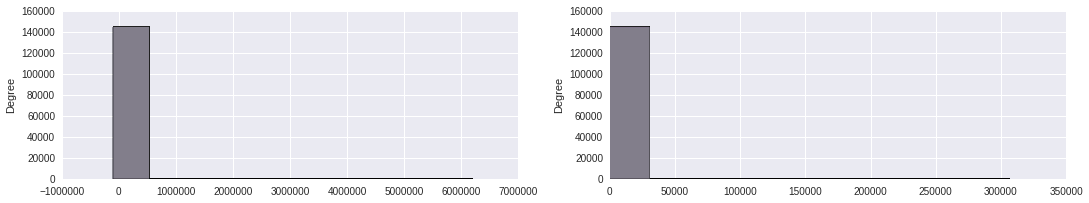

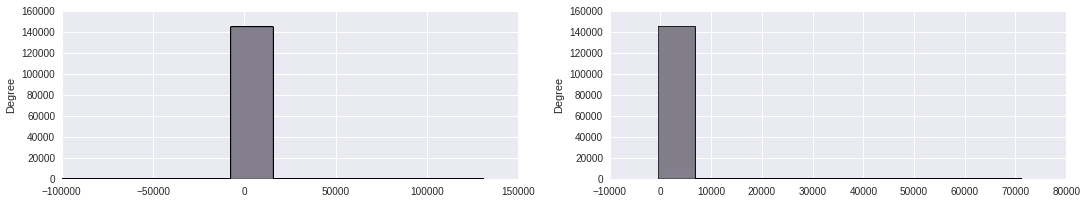

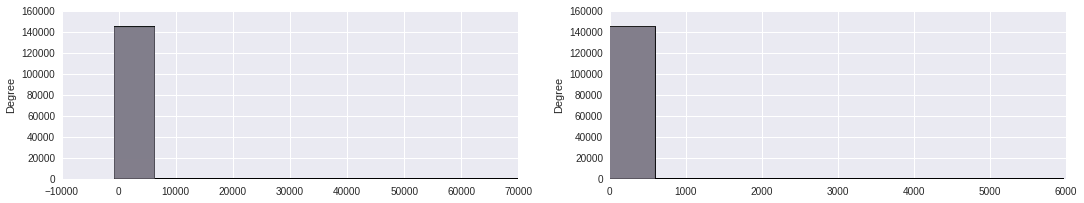

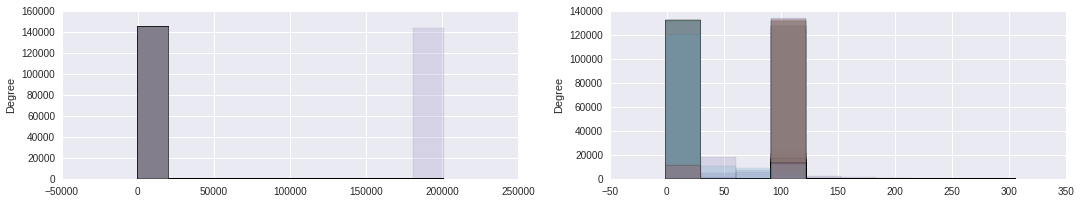

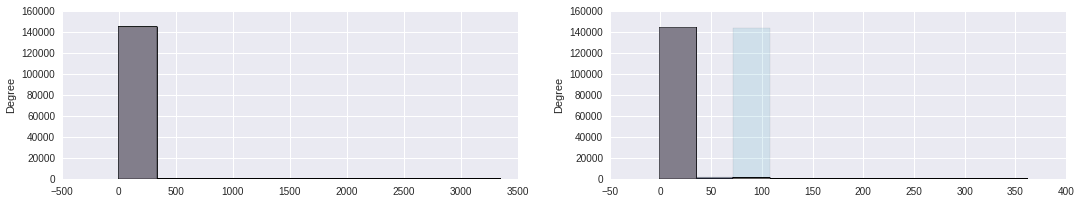

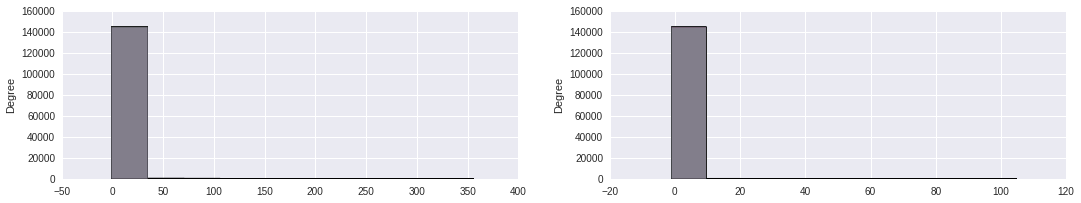

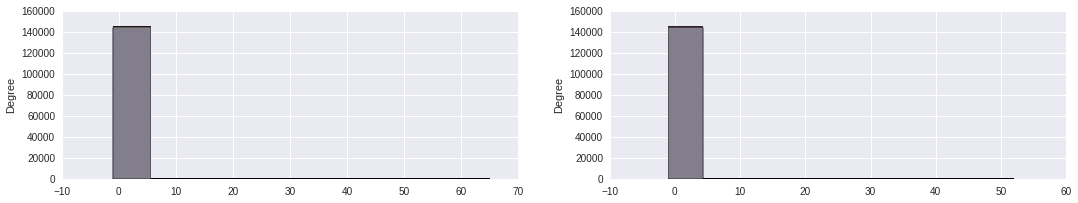

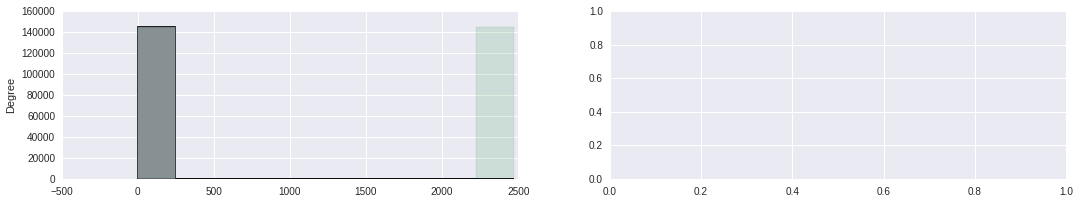

In [6]:
hist_columns(df, X.index, 10, 100)

There seem to be several columns that use big values as NaNs, specially in panels 2, 3, 11, 12, 14 and 19.
Let's first take a closer look at panels 1 to 5, to see why it's the one with highest std.

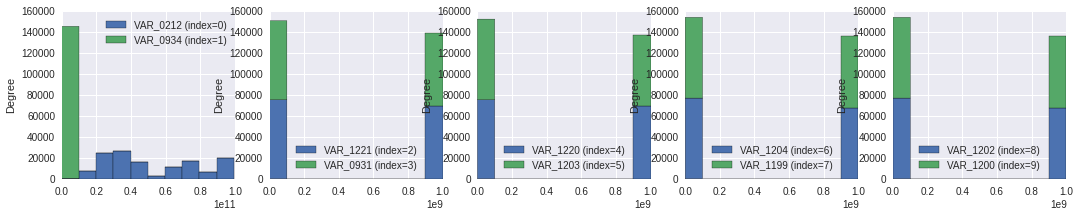

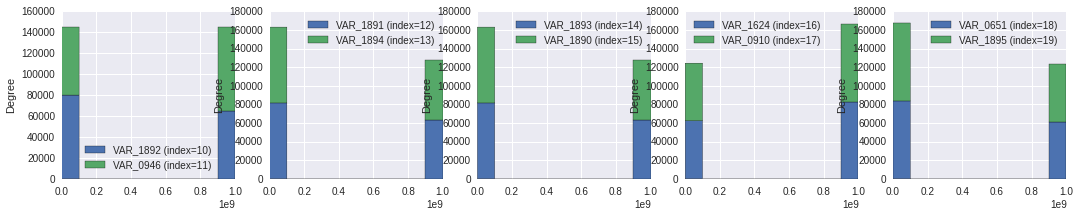

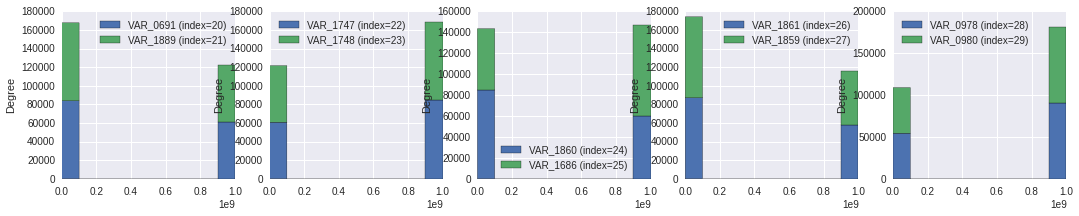

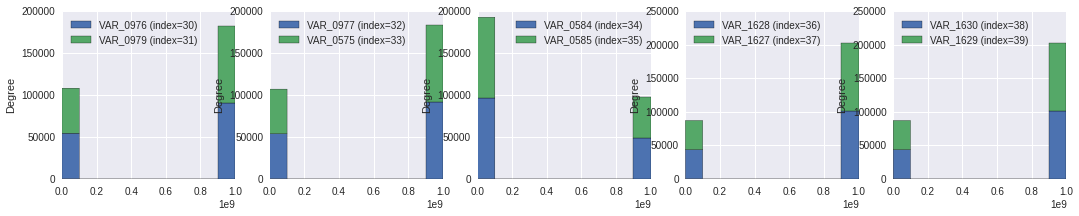

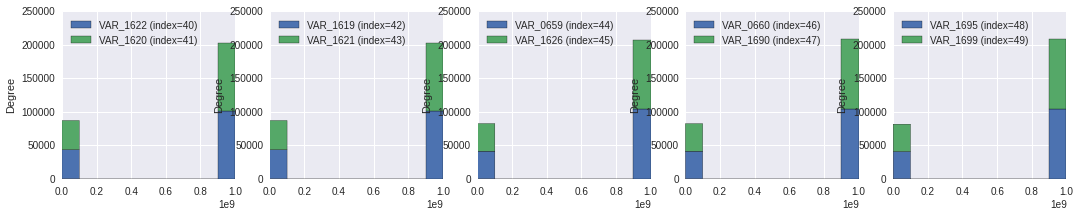

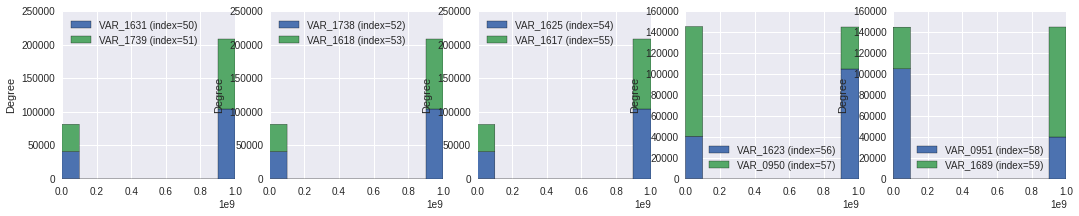

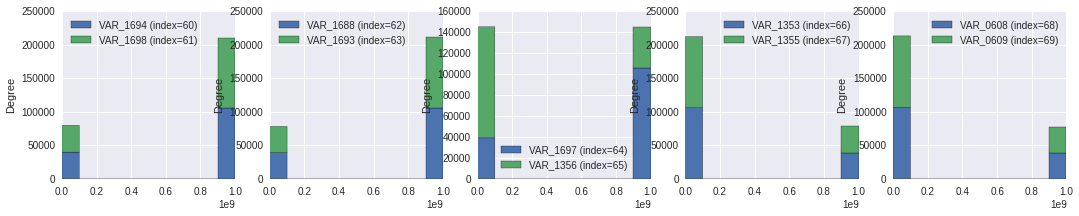

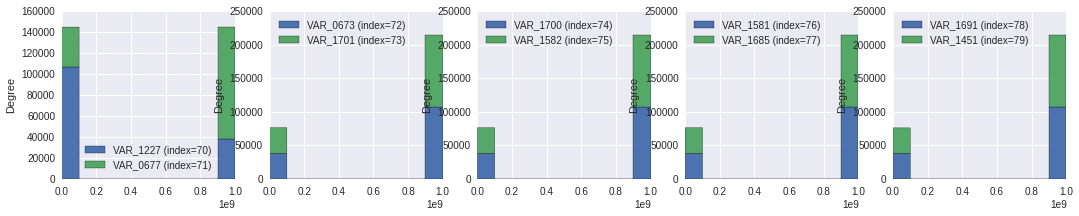

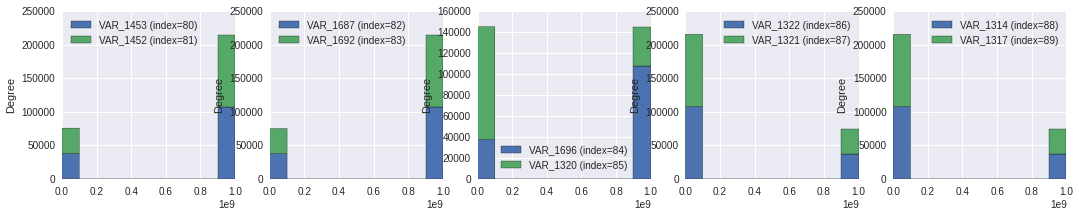

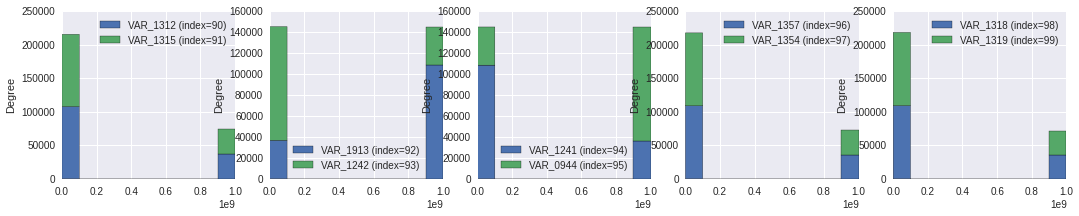

In [29]:
hist_columns(df, X.index, 10, 2, init=0, subplots=5, legend=True, alpha=1, stacked=True)

From the histograms above, it seems like VAR_0212 is truly spread across the range, but the rest of the columns (X.index[1:100]) are using a big value as NaNs. Let's replace everything above 2E8 with NaN in X.index[1:100] and plot again.

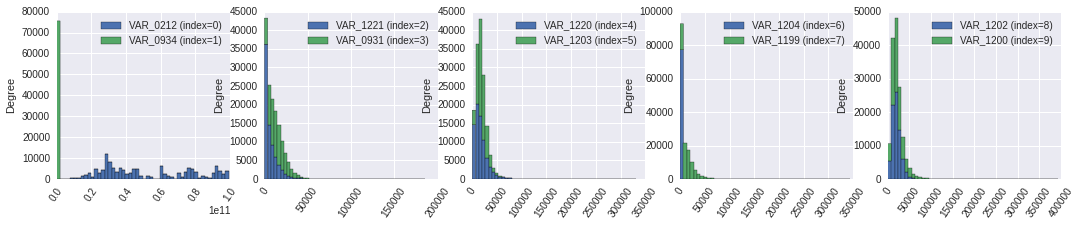

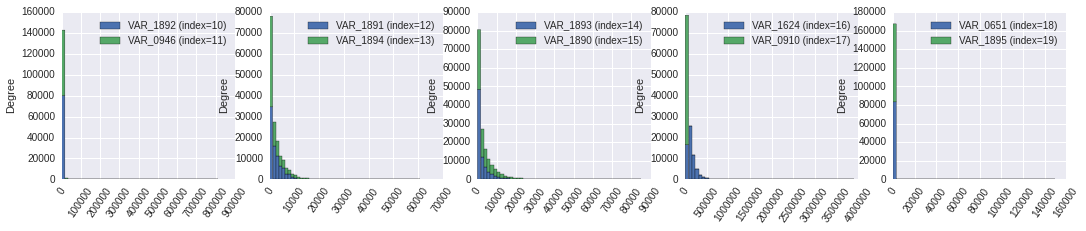

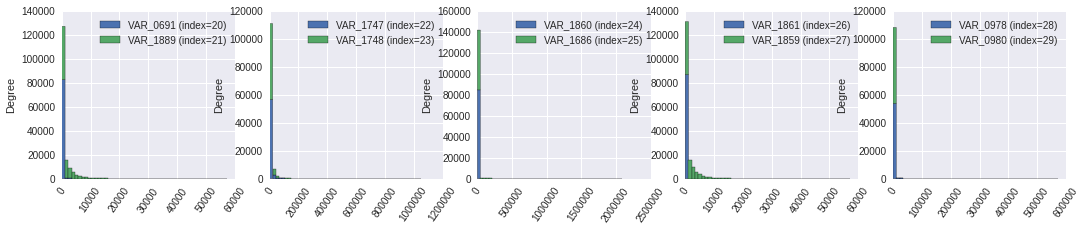

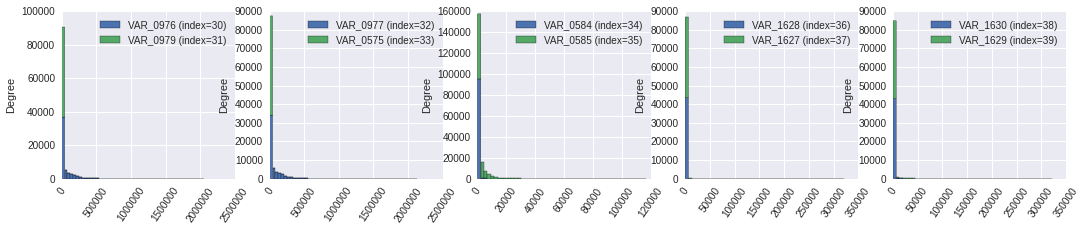

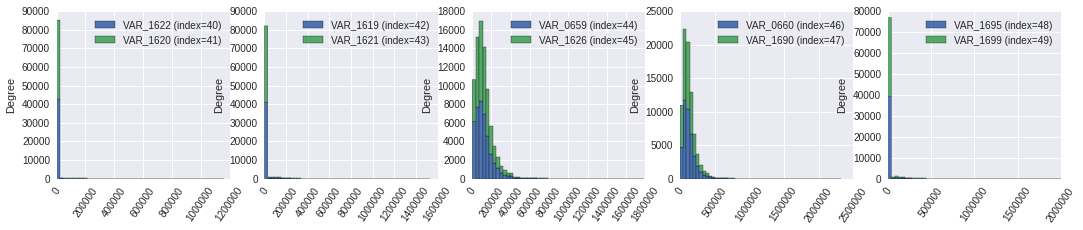

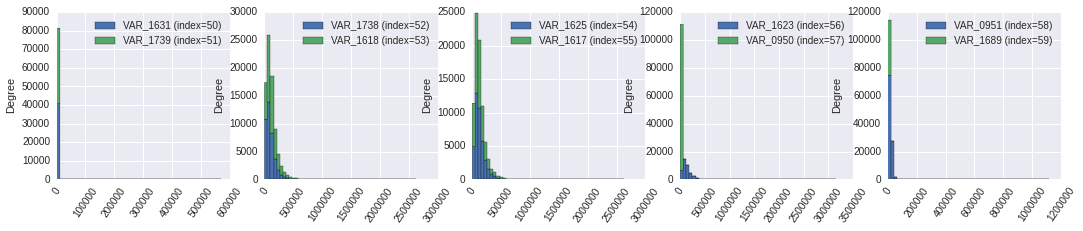

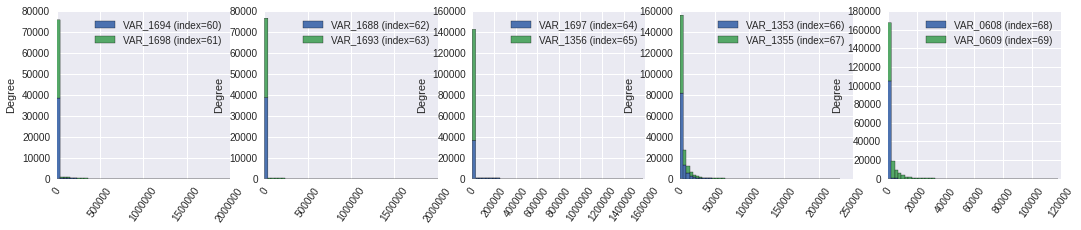

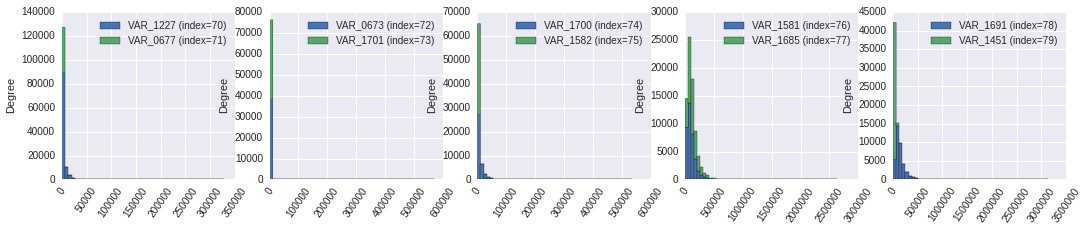

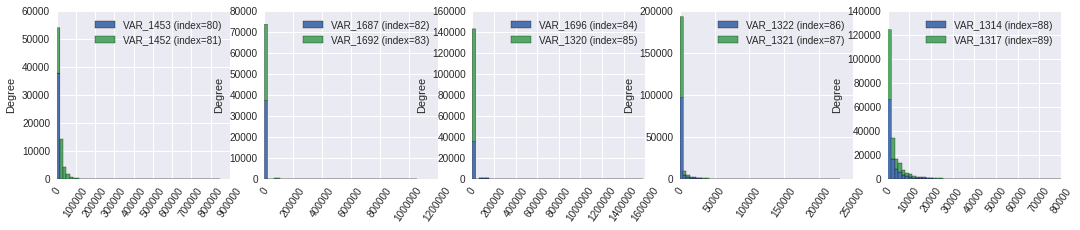

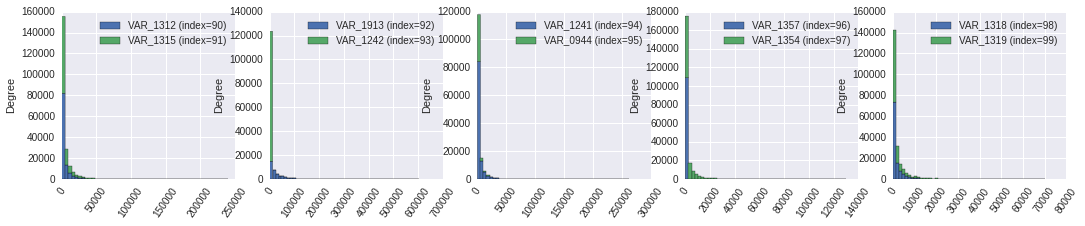

In [54]:
index = X.index[:100]
tmp = df[index]
# This modifies a **copy** of the data
for c in index[1:]:
    tmp.loc[tmp[c] > 2E8, c] = np.nan
hist_columns(tmp, X.index, 10, 2, init=0, subplots=5, legend=True, alpha=1, stacked=True, bins=50)

Looks good, let's make it permanent.

In [55]:
index = X.index[:100]
for c in index[1:]:
    df.loc[df[c] > 2E8, c] = np.nan

Perform the same analysis for the columns in X.index[100:200]

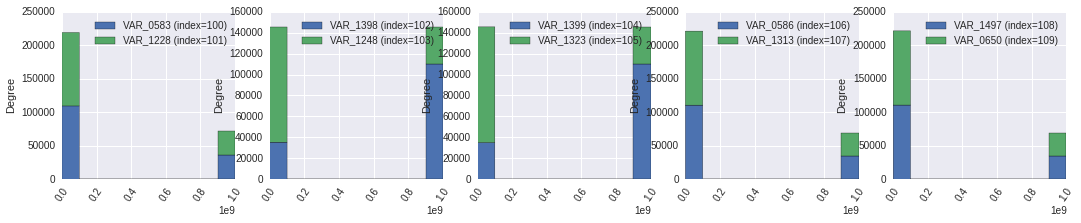

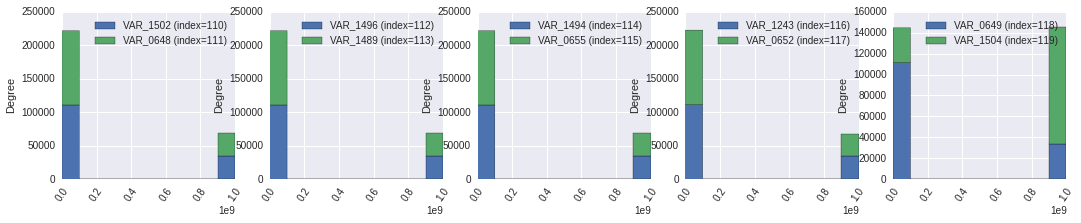

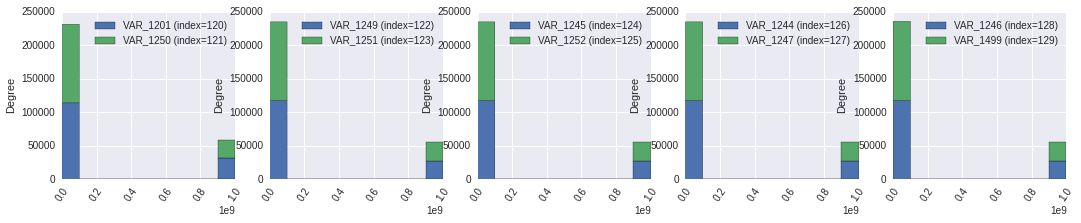

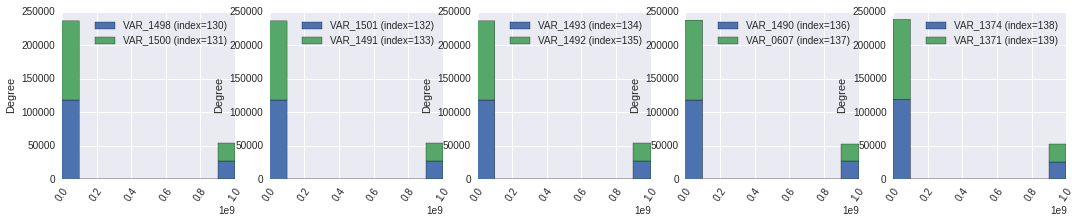

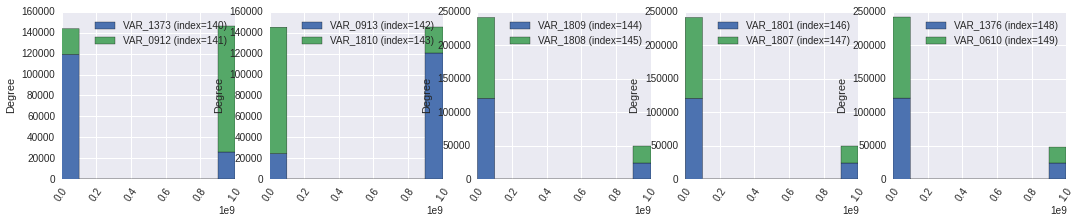

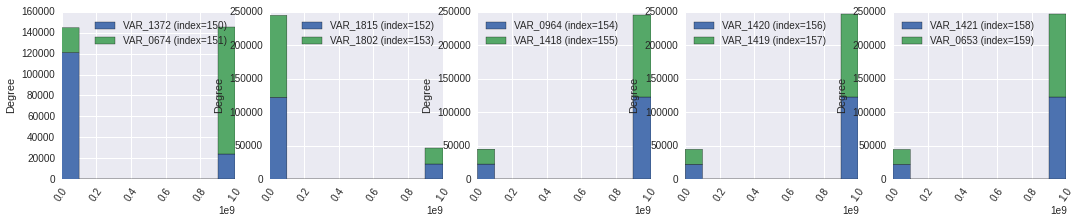

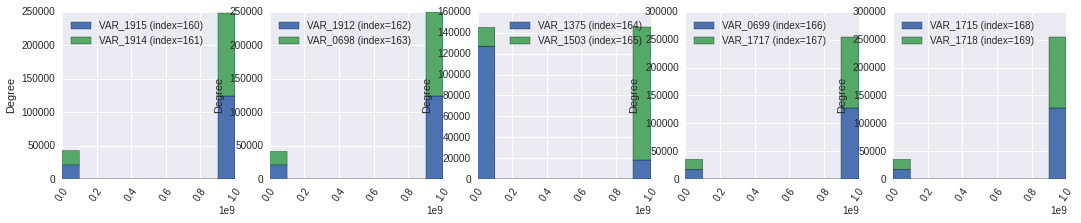

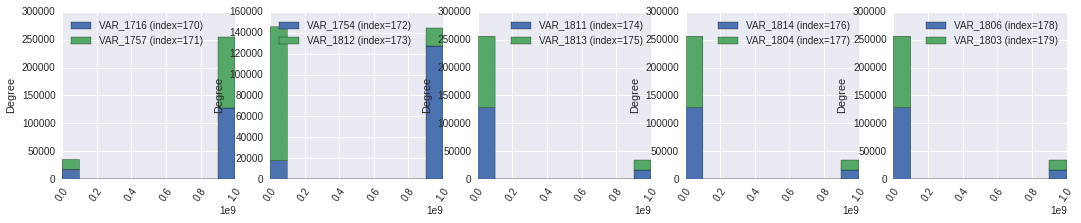

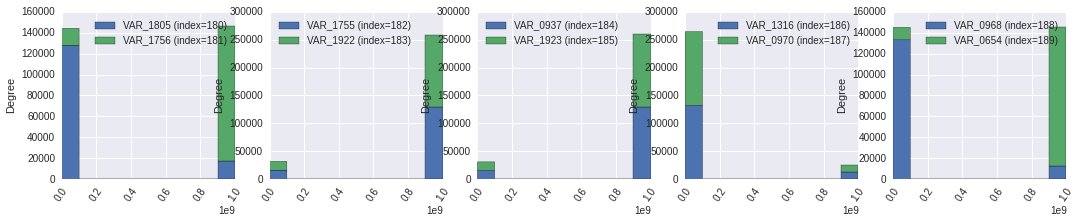

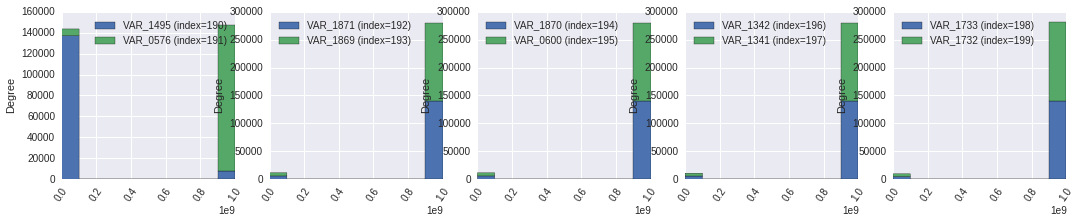

In [57]:
hist_columns(df, X.index, 10, 2, init=100, subplots=5, legend=True, alpha=1, stacked=True)

Same as before, replace everything above 0.8E9 with NaN in X.index[100:200] and plot again.

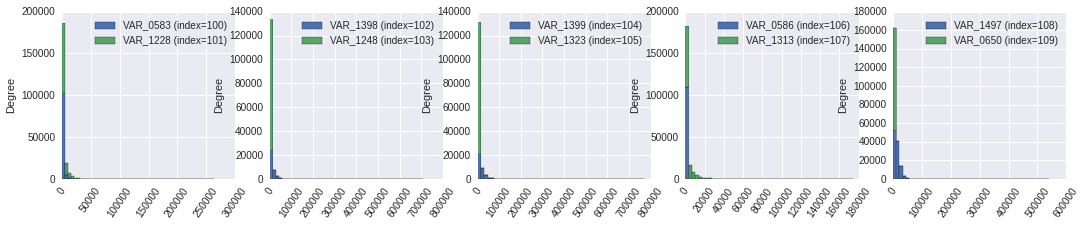

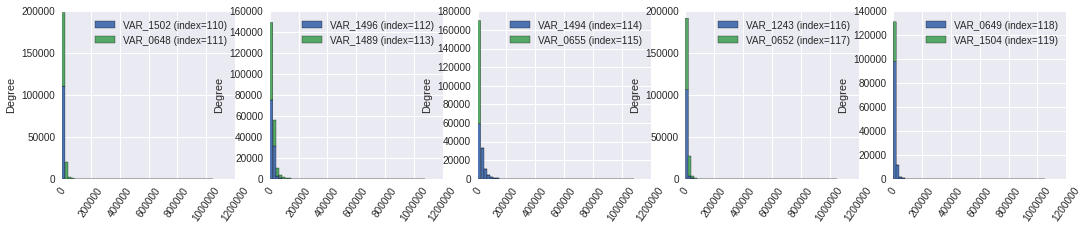

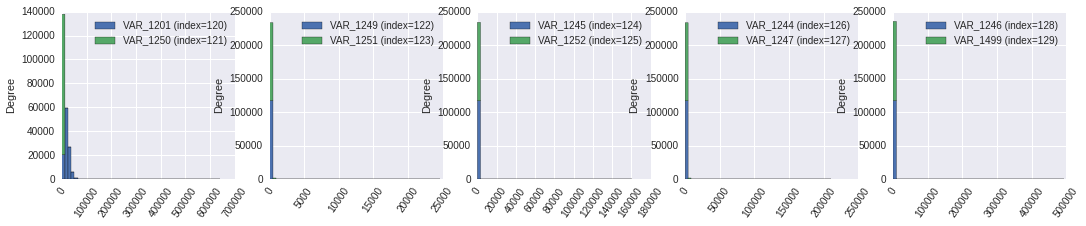

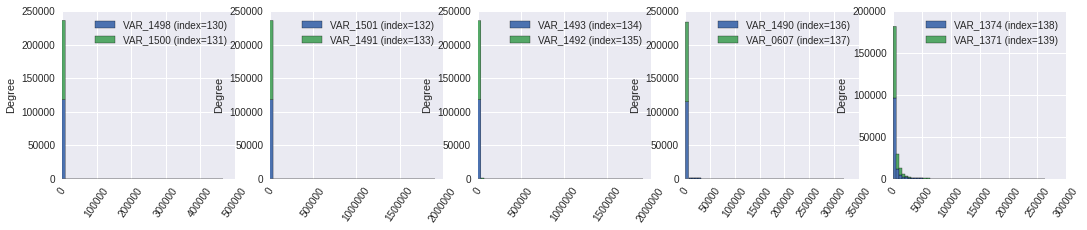

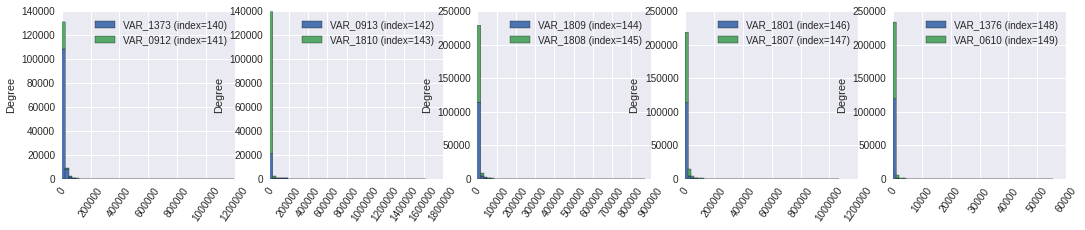

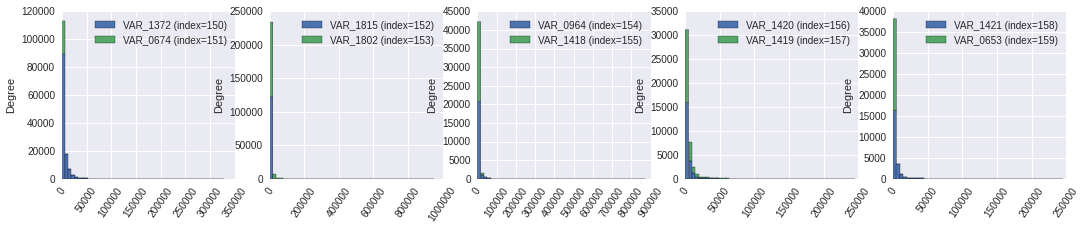

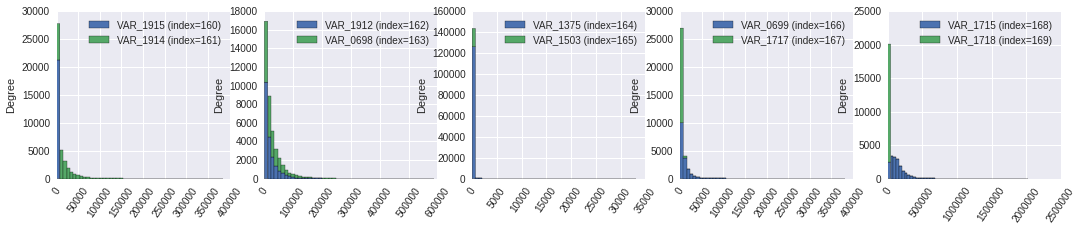

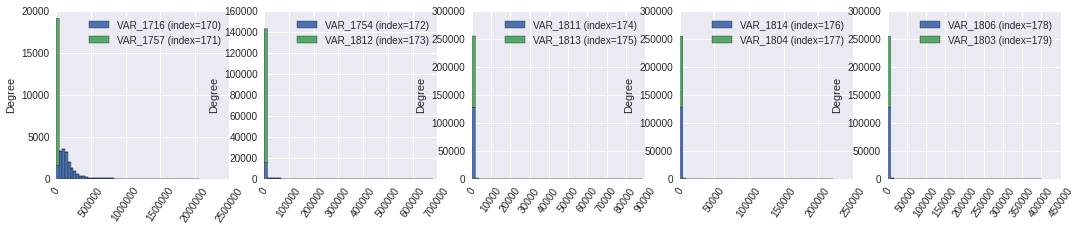

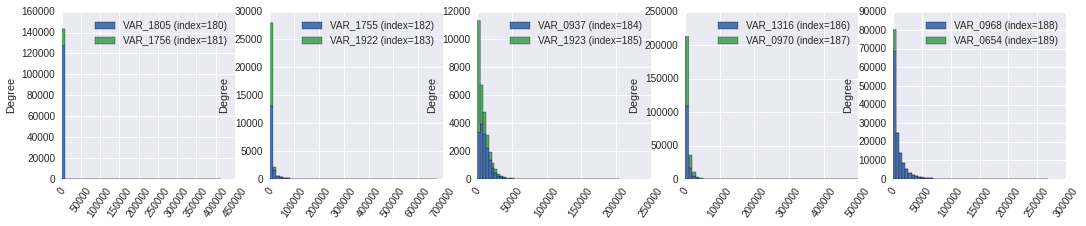

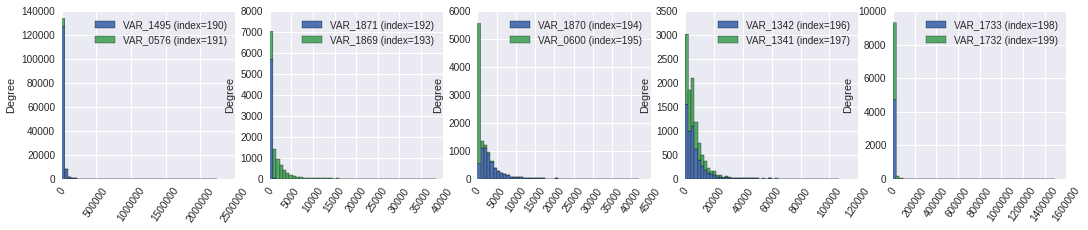

In [59]:
index = X.index[100:200]
tmp = df[index]
for c in index:
    tmp.loc[tmp[c] > 8E8, c] = np.nan
hist_columns(tmp, X.index, 10, 2, init=100, subplots=5, legend=True, alpha=1, stacked=True, bins=50)

Looks good, let's make it permanent.

In [60]:
index = X.index[100:200]
for c in index:
    df.loc[df[c] > 8E8, c] = np.nan

Perform the same analysis for the columns in X.index[200:300]

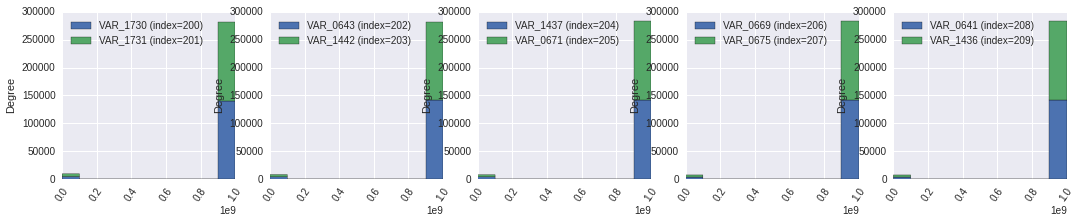

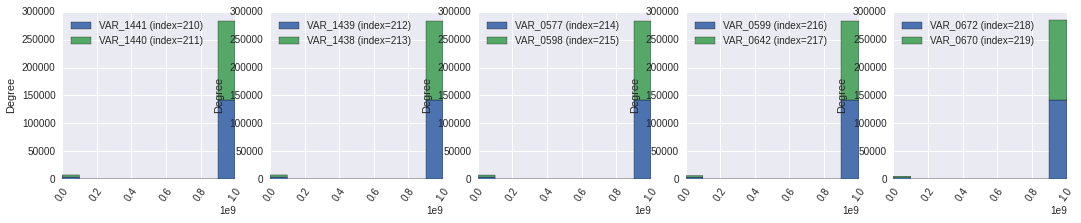

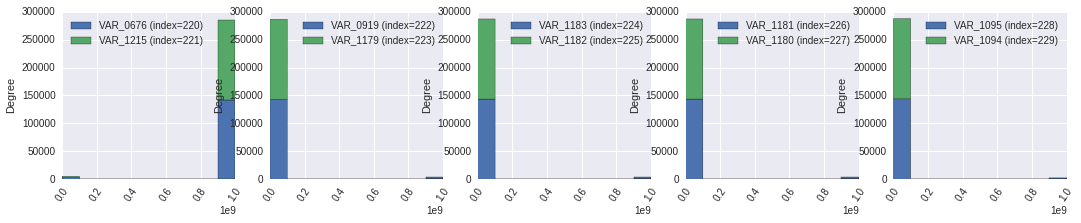

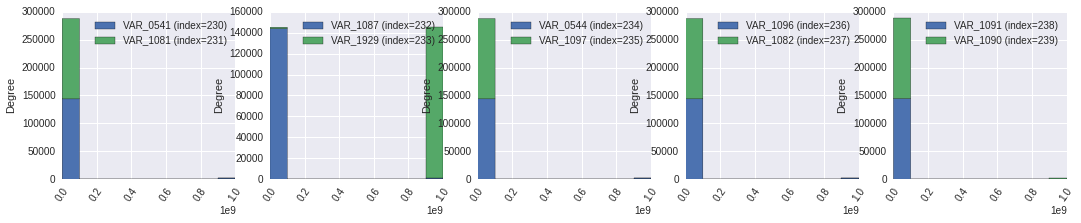

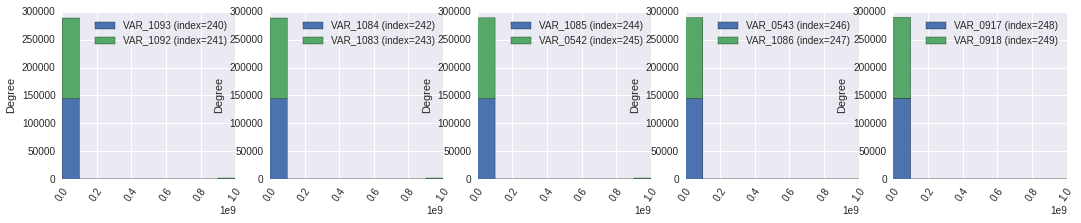

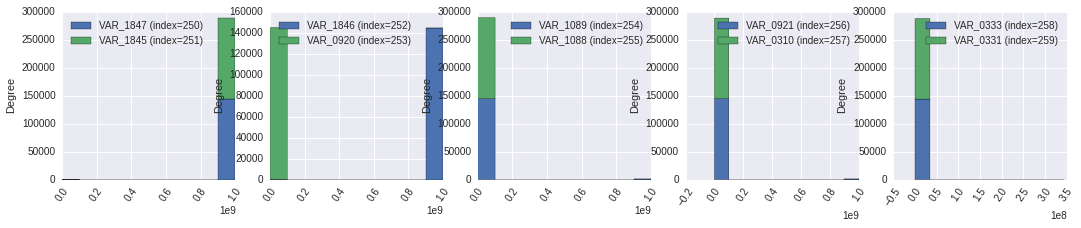

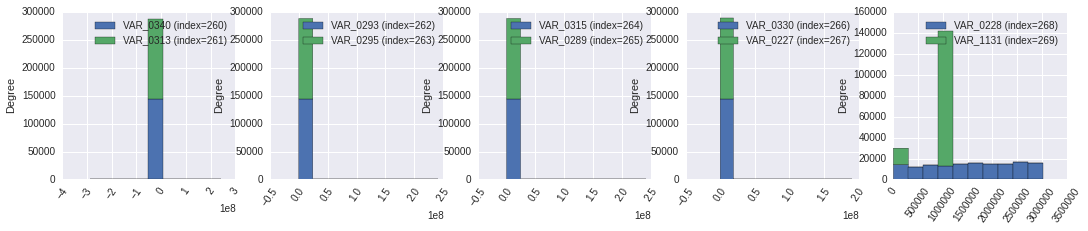

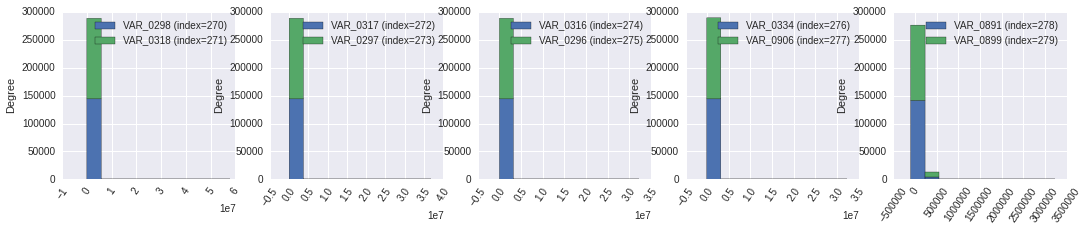

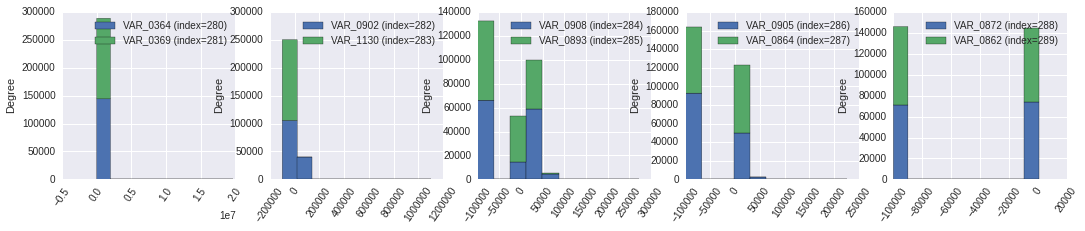

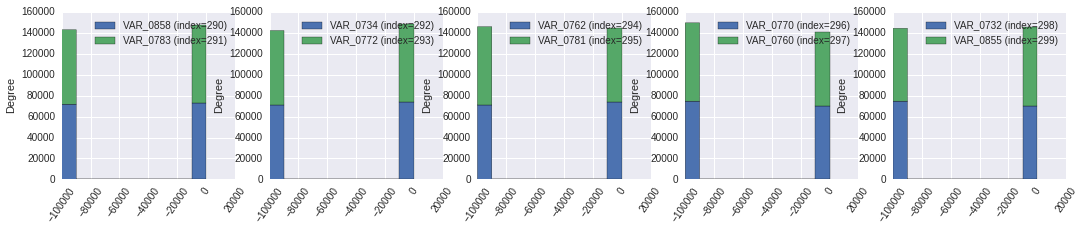

In [61]:
hist_columns(df, X.index, 10, 2, init=200, subplots=5, legend=True, alpha=1, stacked=True)

Replace everything above 0.8E9 in X.index[200:258], everything above 8E5 in X.index[269], everything below -8E4 in X.index[282] and X.index[284:300] with NaNs and plot again.

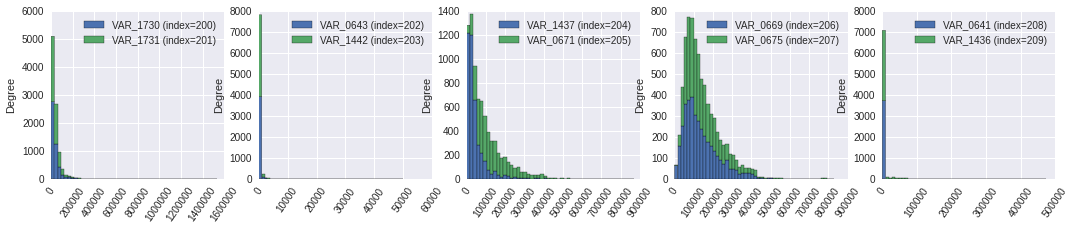

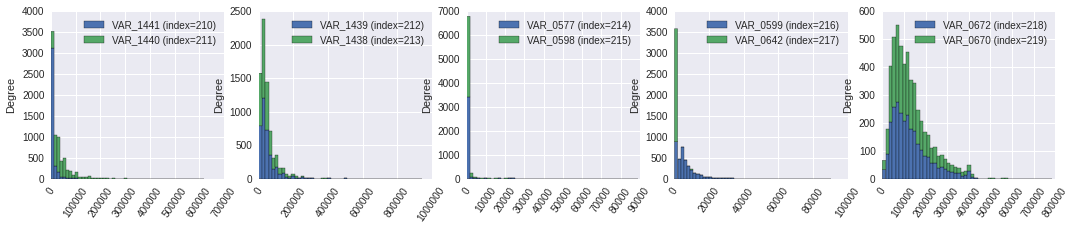

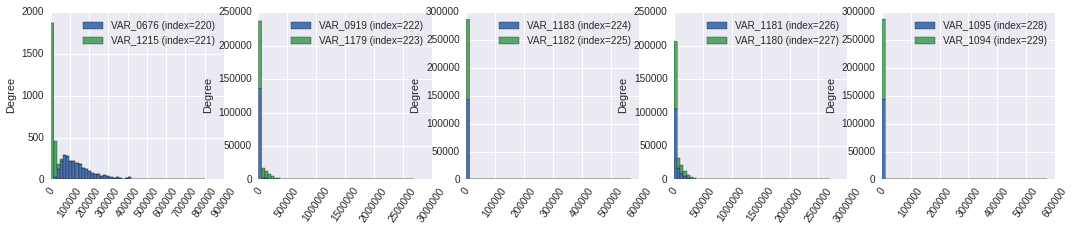

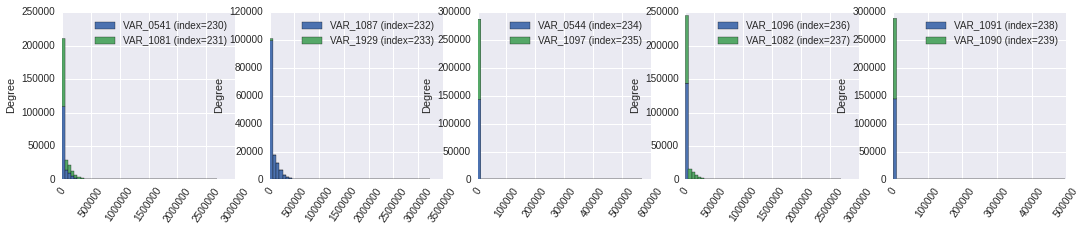

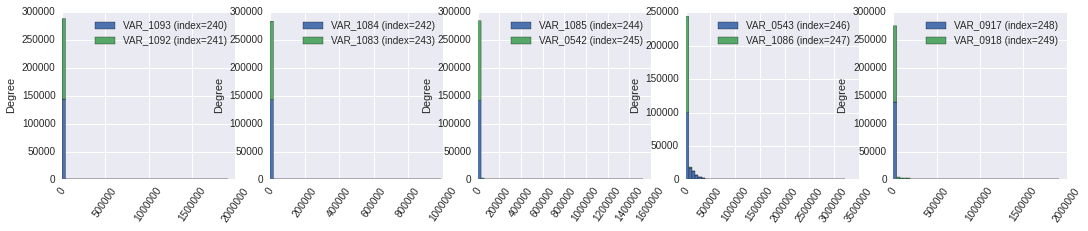

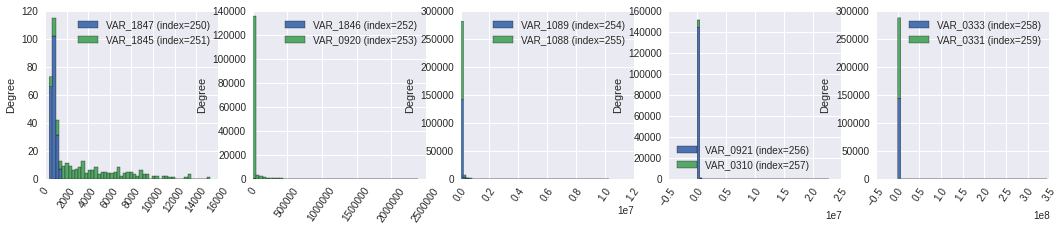

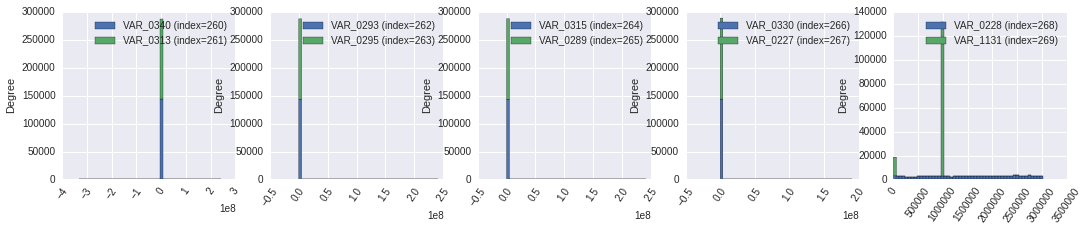

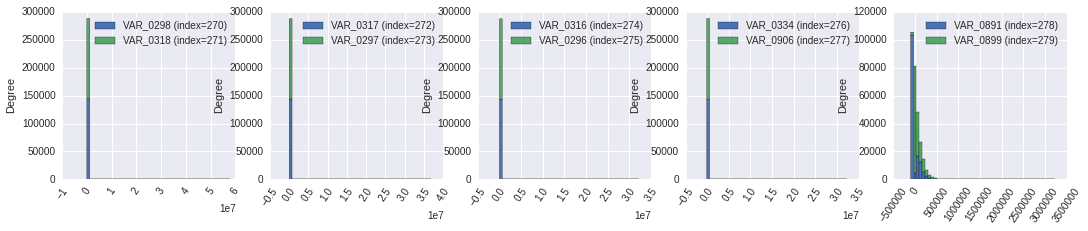

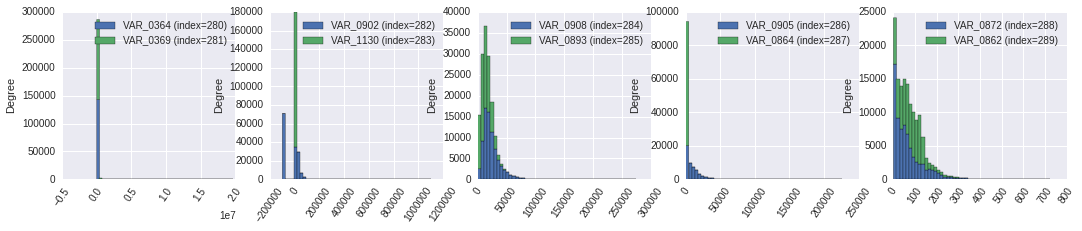

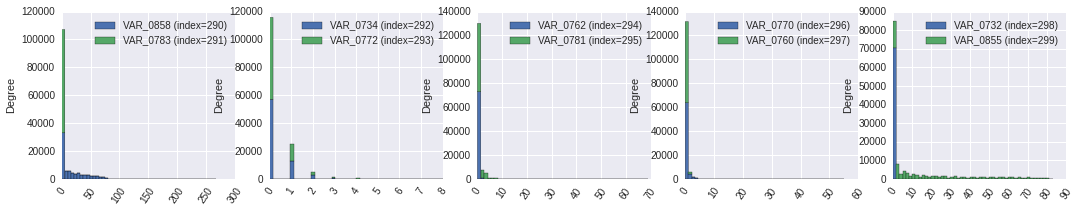

In [92]:
index = X.index
tmp = df[index[200:300]]
for c in index[200:258]:
    tmp.loc[tmp[c] > 8E8, c] = np.nan

tmp.loc[tmp[index[269]] > 8E5, c] = np.nan
tmp.loc[tmp[index[282]] < -8E4, c] = np.nan

for c in index[284:300]:
    tmp.loc[tmp[c] < -8E4, c] = np.nan
    
hist_columns(tmp, X.index, 10, 2, init=200, subplots=5, legend=True, alpha=1, stacked=True, bins=50)

Looks good, let's make it permanent.

In [94]:
index = X.index
for c in index[200:258]:
    df.loc[df[c] > 8E8, c] = np.nan

df.loc[df[index[269]] > 8E5, c] = np.nan
df.loc[df[index[282]] < -8E4, c] = np.nan

for c in index[284:300]:
    df.loc[tmp[c] < -8E4, c] = np.nan


Perform the same analysis for the columns in X.index[300:400]

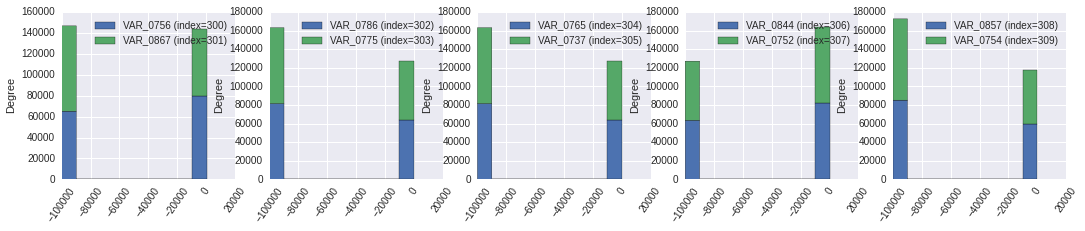

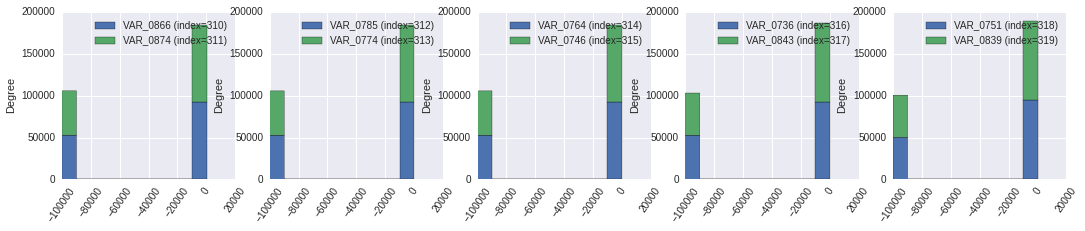

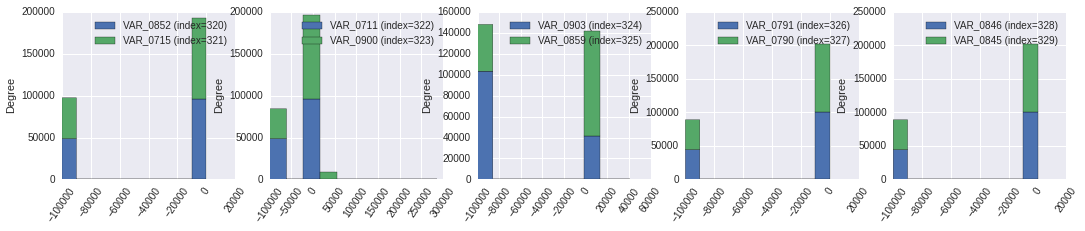

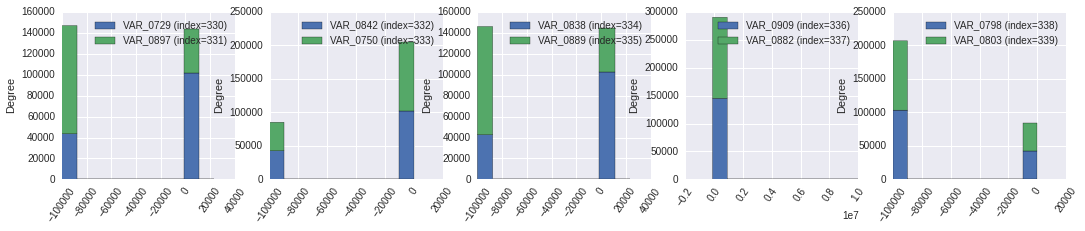

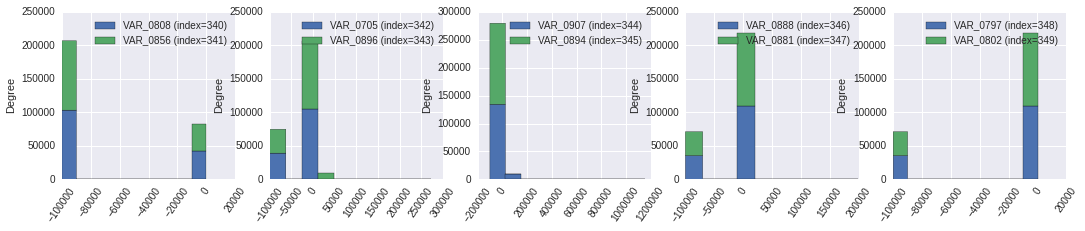

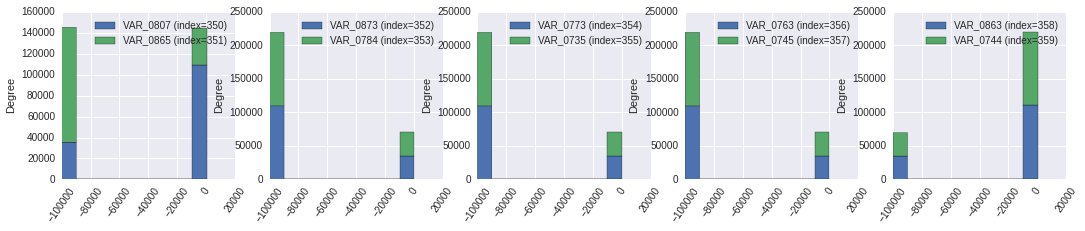

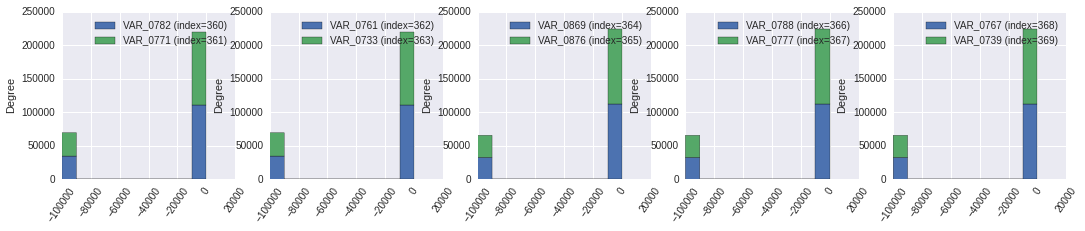

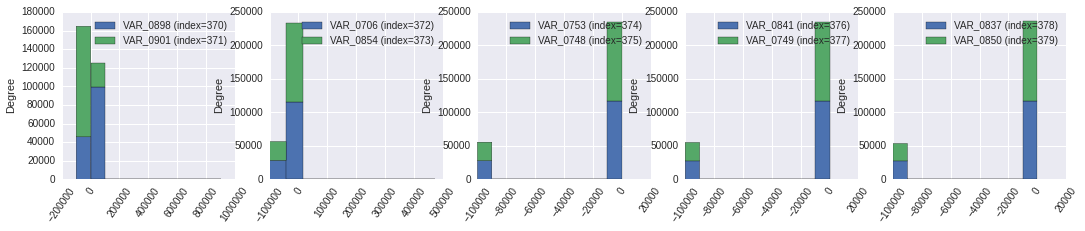

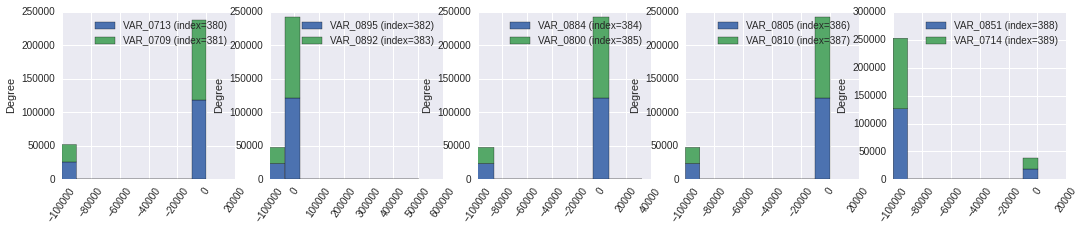

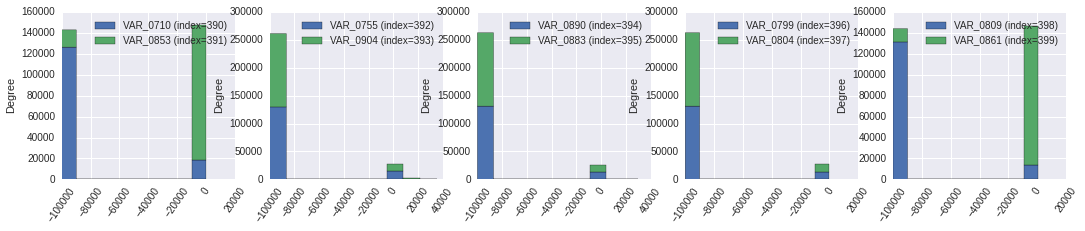

In [95]:
hist_columns(df, X.index, 10, 2, init=300, subplots=5, legend=True, alpha=1, stacked=True)

Replace everything below -8E4 in X.index[300:336] and X.index[337:400], and everything above 8E6 in X.index[336] with NaNs and plot again.

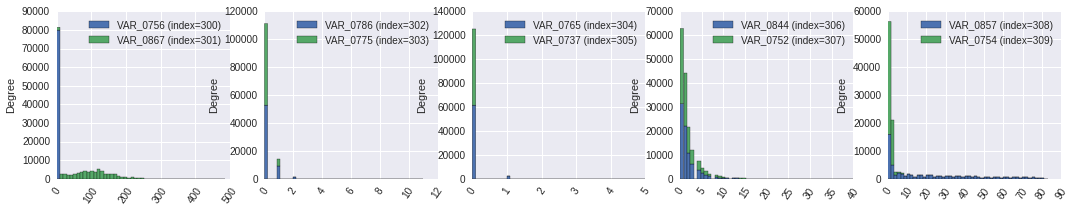

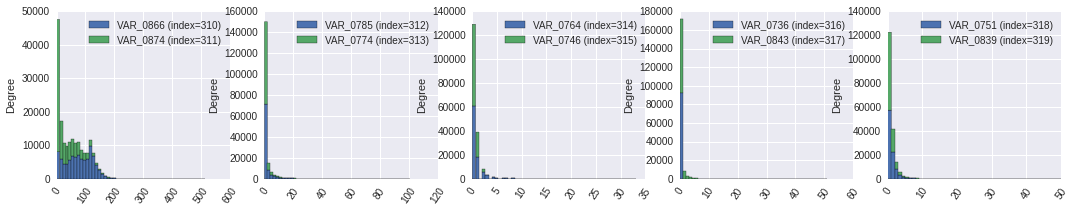

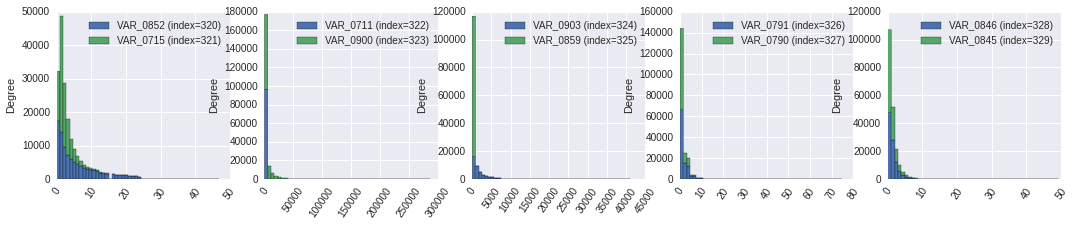

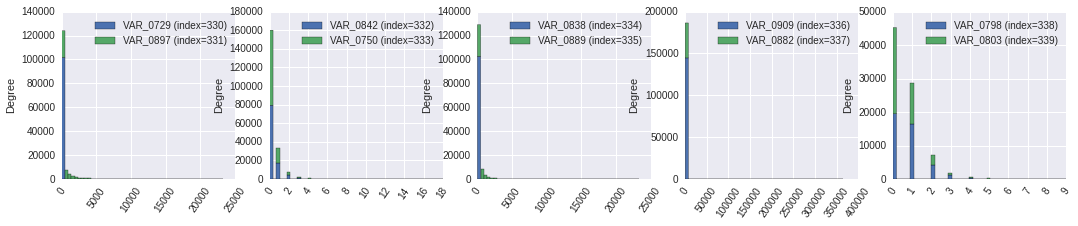

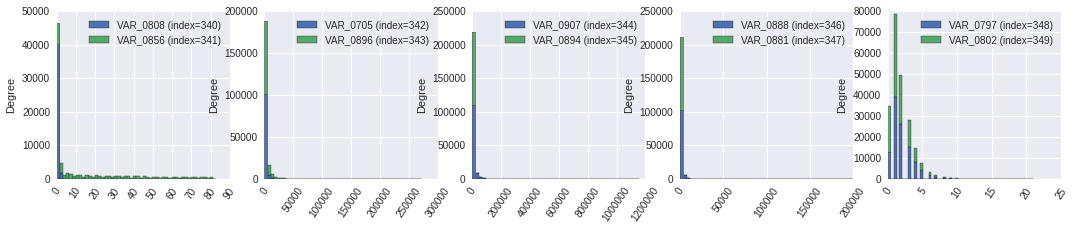

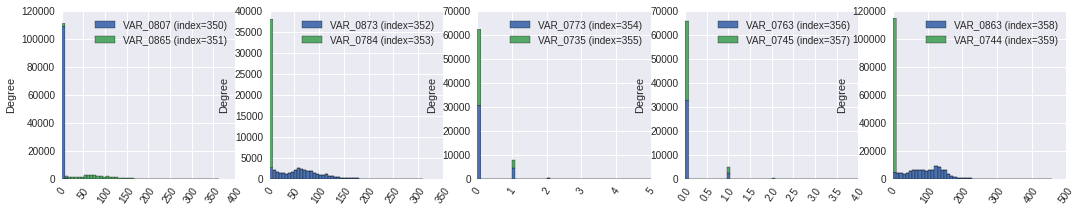

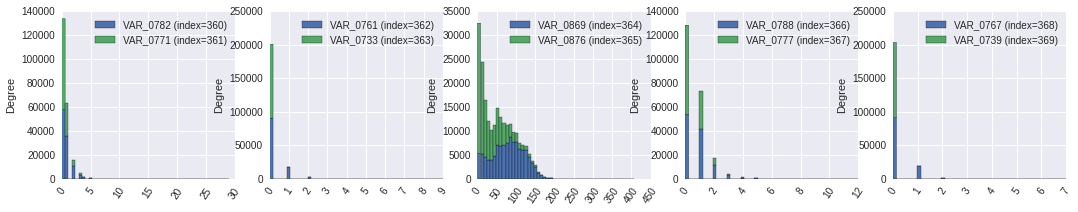

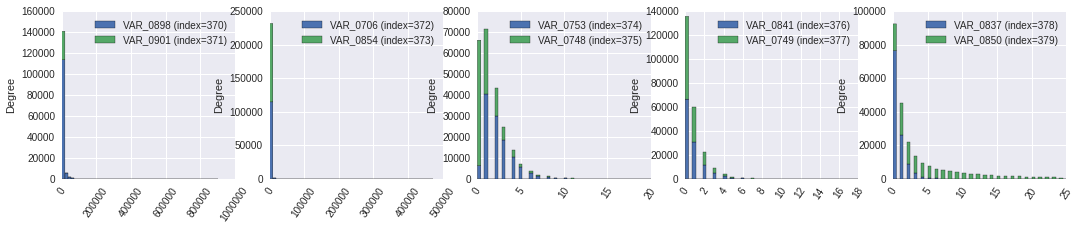

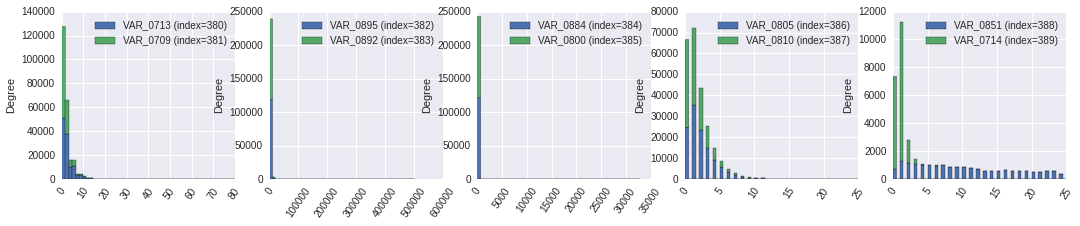

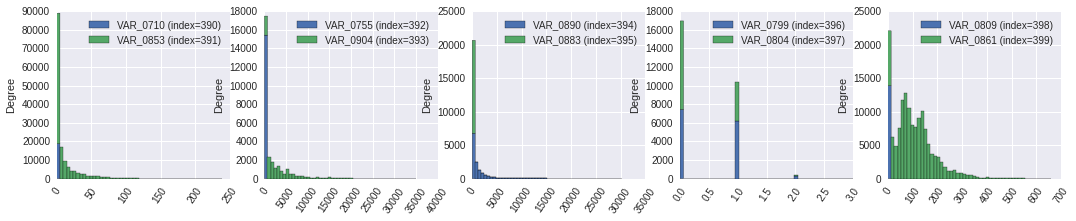

In [105]:
index = X.index[300:400]
tmp = df[index]
for c in index:
    if c == 'VAR_0909':
        tmp.loc[tmp[c] > 8E6, c] = np.nan
    else:
        tmp.loc[tmp[c] < -8E4, c] = np.nan

hist_columns(tmp, X.index, 10, 2, init=300, subplots=5, legend=True, alpha=1, stacked=True, bins=50)

Looks good, let's make it permanent.

In [106]:
index = X.index[300:400]
for c in index:
    if c == 'VAR_0909':
        df.loc[df[c] > 8E6, c] = np.nan
    else:
        df.loc[df[c] < -8E4, c] = np.nan


Perform the same analysis for the columns in X.index[400:500]

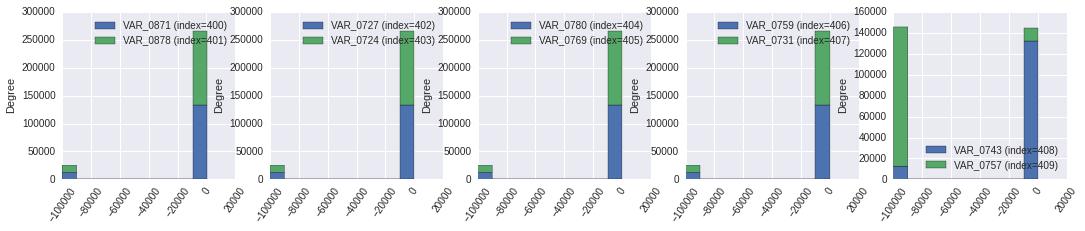

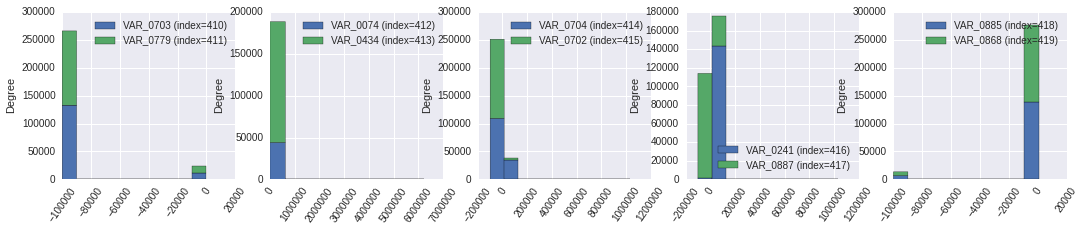

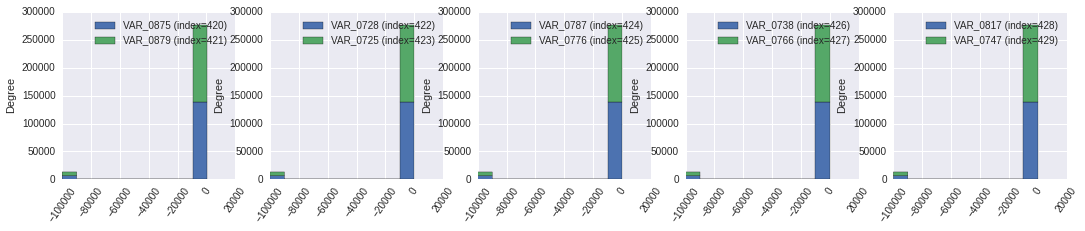

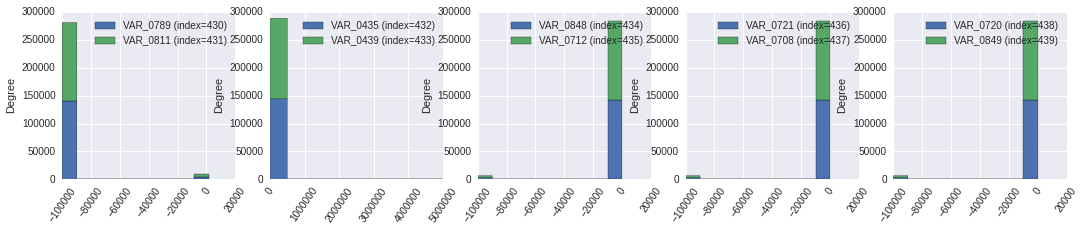

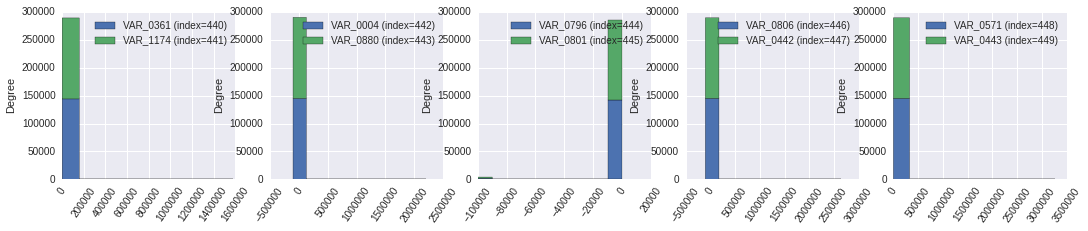

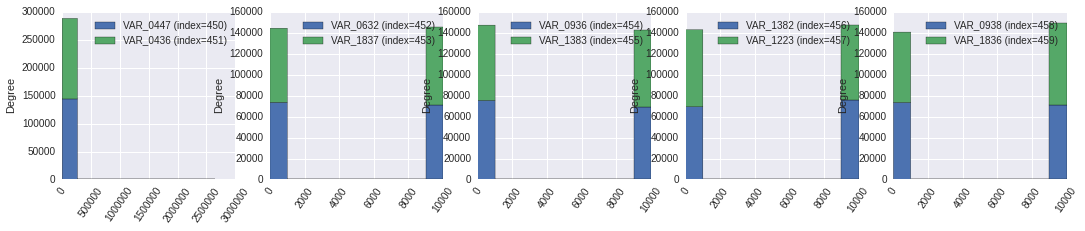

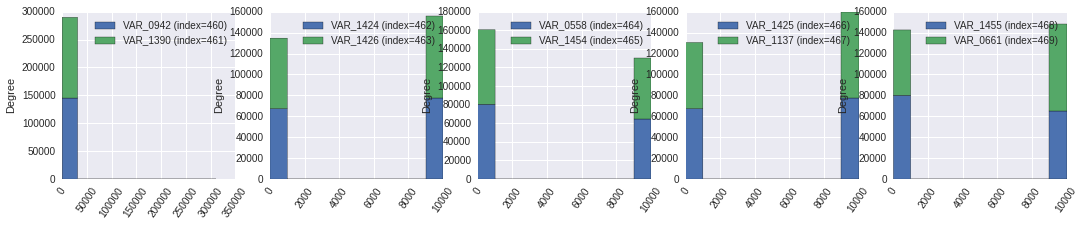

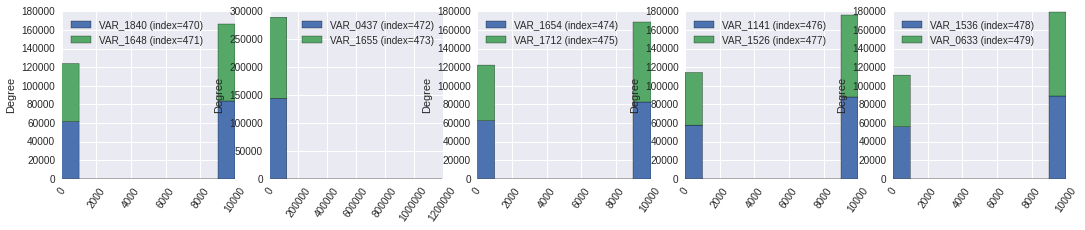

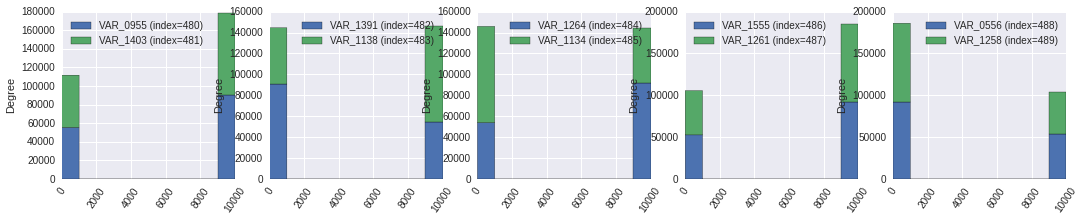

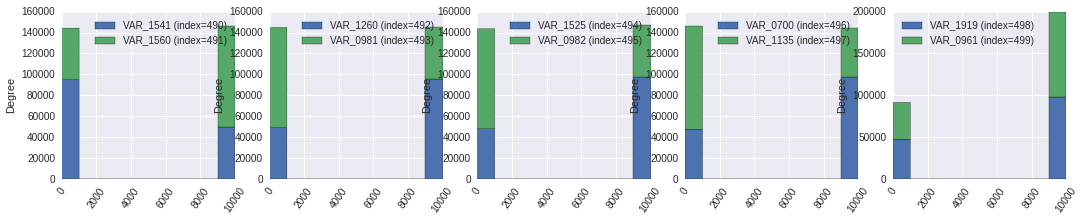

In [107]:
hist_columns(df, X.index, 10, 2, init=400, subplots=5, legend=True, alpha=1, stacked=True)

Replace everything below -8E4 in X.index[400:447] except 412, 413, 416, 432, 433, 440, 441, 442 and 443, and everything above 8E3 in X.index[452:500] except 461 and 472 with NaNs and plot again.

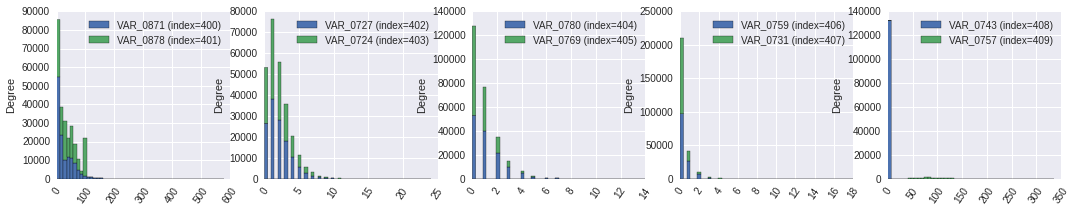

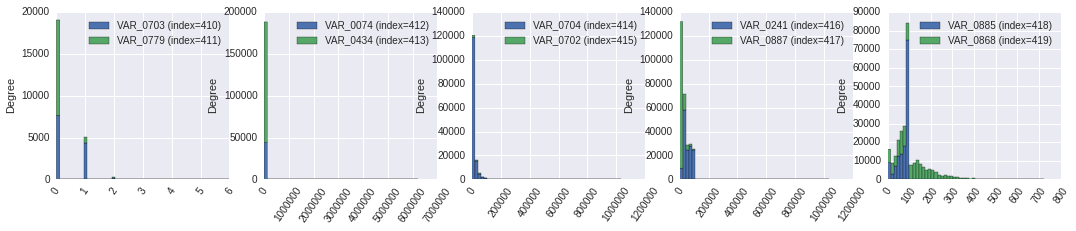

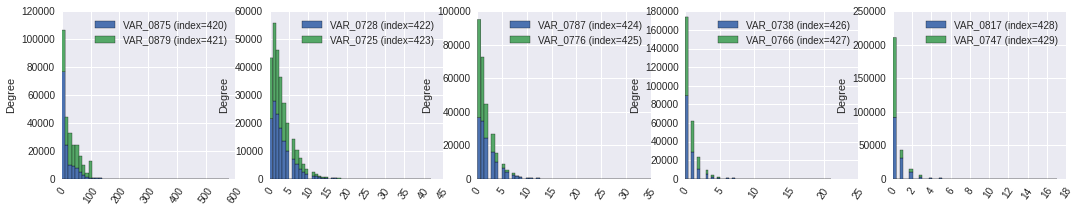

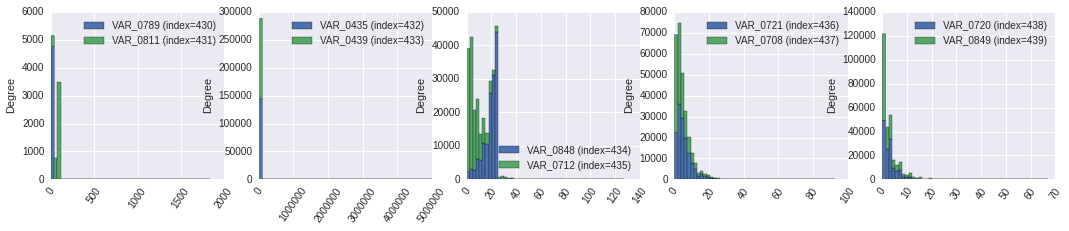

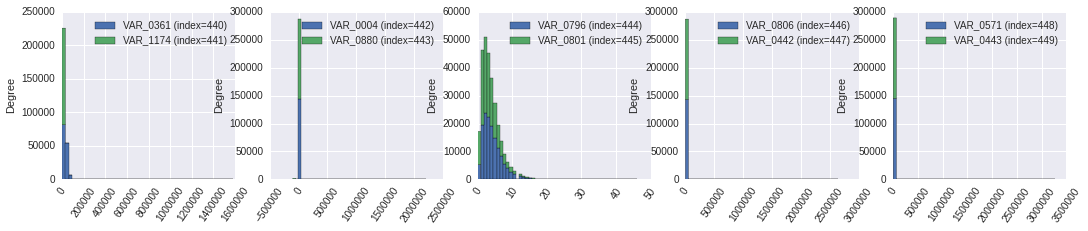

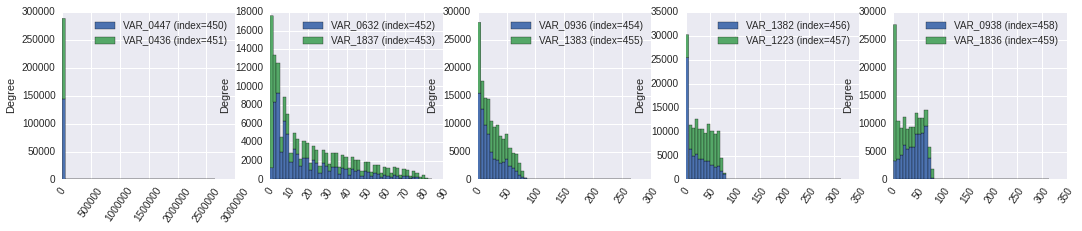

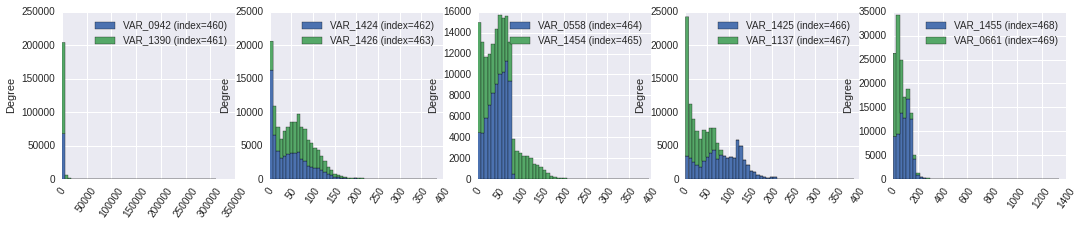

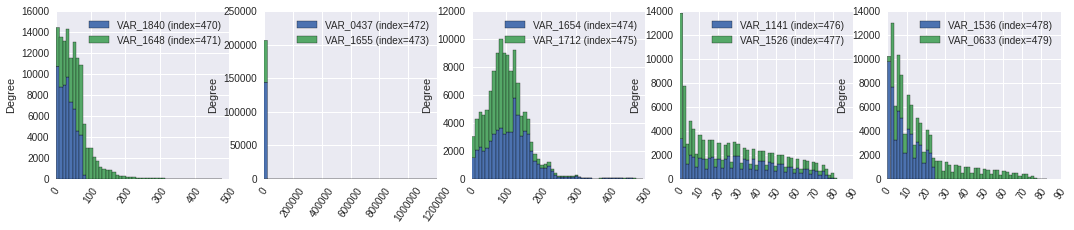

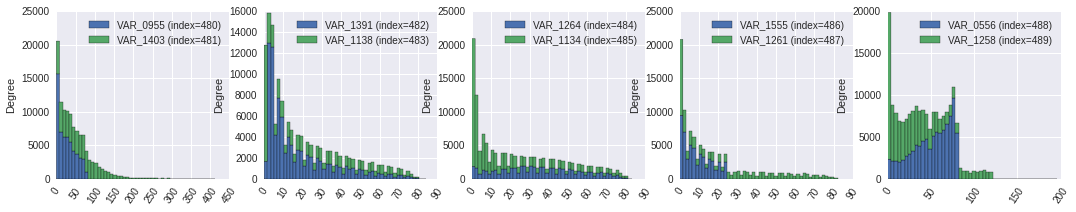

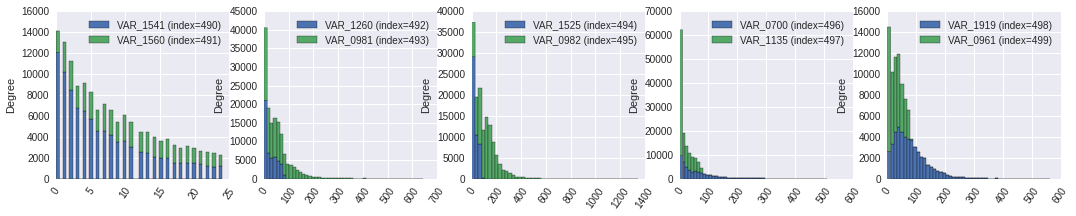

In [117]:
index = X.index[400:500]
tmp = df[index]
ex_set = set([412, 413, 416, 432, 433, 440, 441, 442, 443])
for i, c in enumerate(index[:47], 400):
    if i not in ex_set:
        tmp.loc[tmp[c] < -8E4, c] = np.nan

ex_set = set([461, 472])
for i, c in enumerate(index[52:], 452):
    if i not in ex_set:
        tmp.loc[tmp[c] > 8E3, c] = np.nan

hist_columns(tmp, X.index, 10, 2, init=400, subplots=5, legend=True, alpha=1, stacked=True, bins=50)

Looks good, let's make it permanent.

In [118]:
index = X.index[400:500]
ex_set = set([412, 413, 416, 432, 433, 440, 441, 442, 443])
for i, c in enumerate(index[:47], 400):
    if i not in ex_set:
        df.loc[df[c] < -8E4, c] = np.nan

ex_set = set([461, 472])
for i, c in enumerate(index[52:], 452):
    if i not in ex_set:
        df.loc[df[c] > 8E3, c] = np.nan


Perform the same analysis for the columns in X.index[500:600]

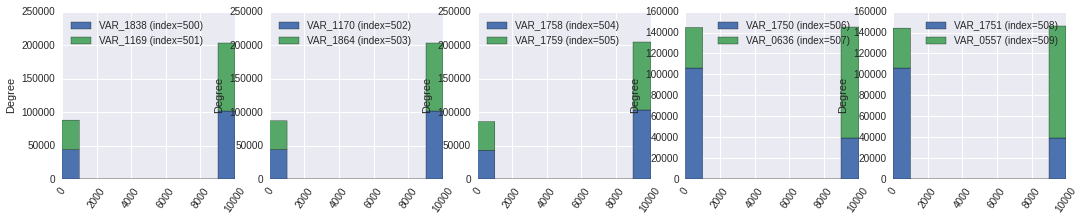

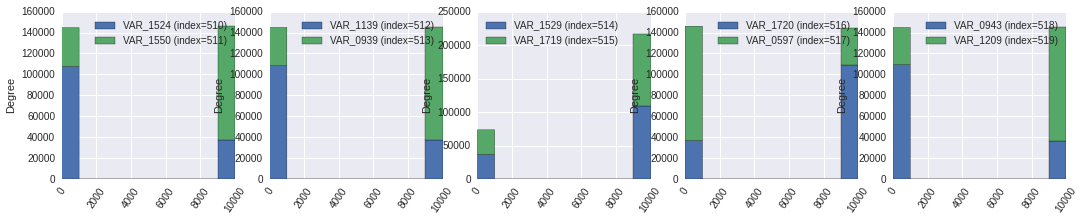

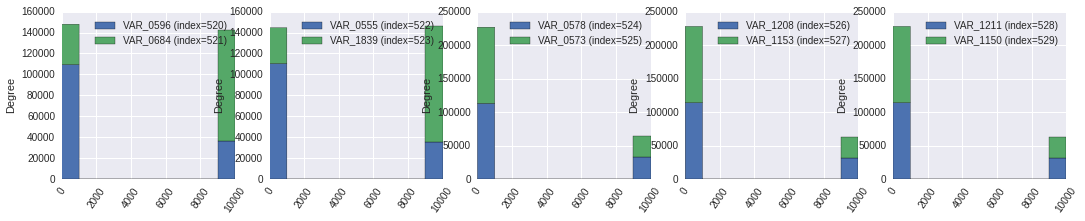

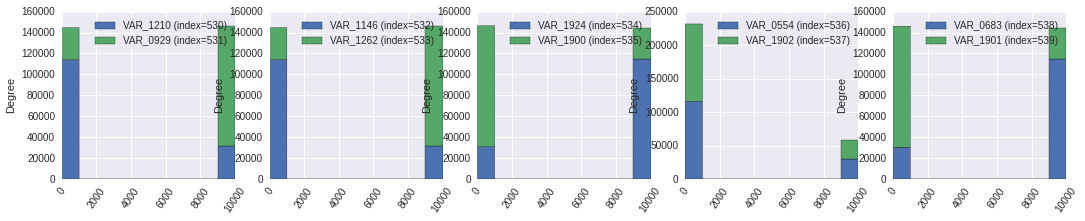

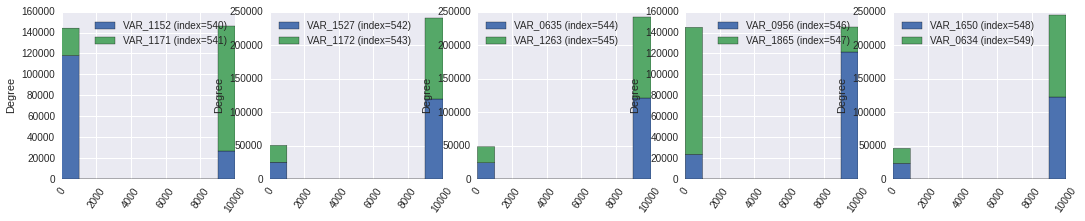

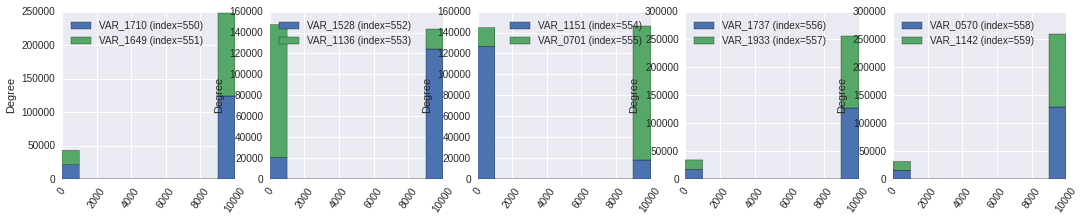

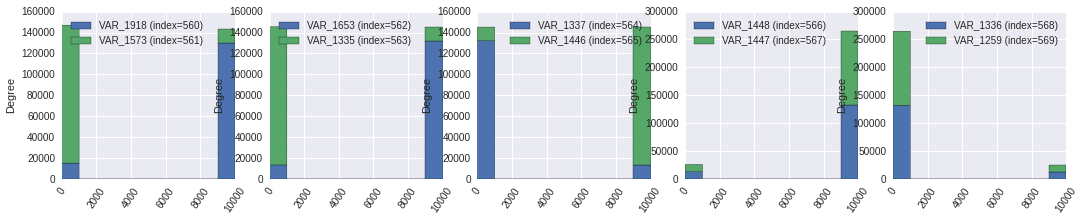

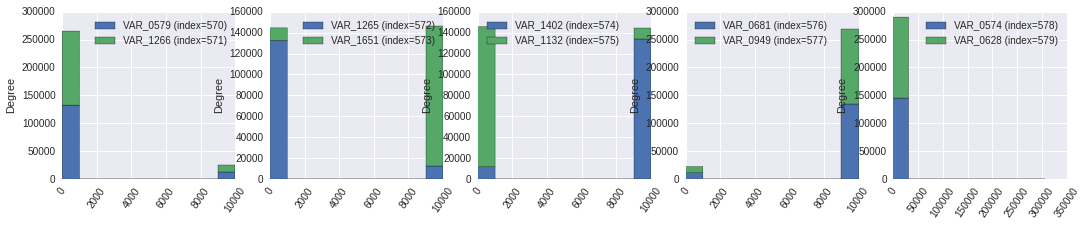

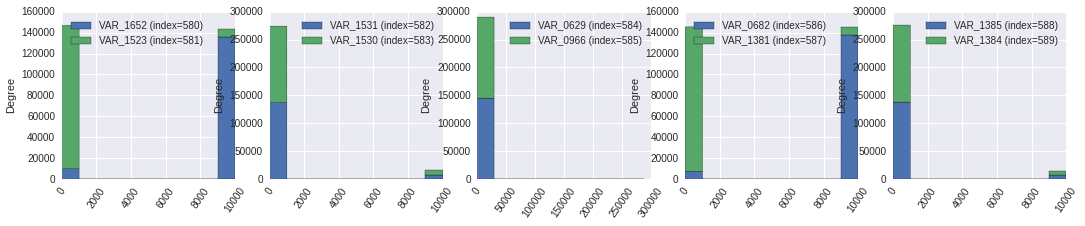

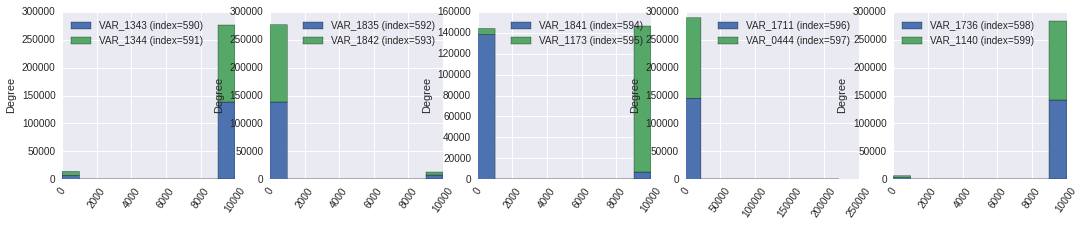

In [119]:
hist_columns(df, X.index, 10, 2, init=500, subplots=5, legend=True, alpha=1, stacked=True)

Replace everything above 8E3 in X.index[500:600] except 579, 584 and 597 with NaNs and plot again.

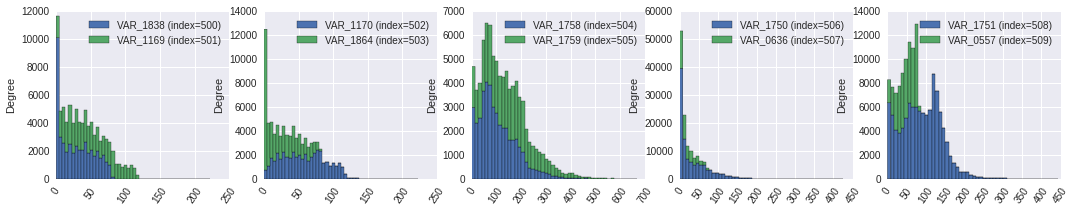

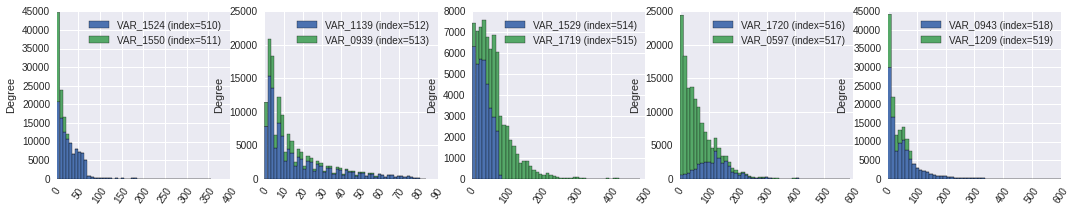

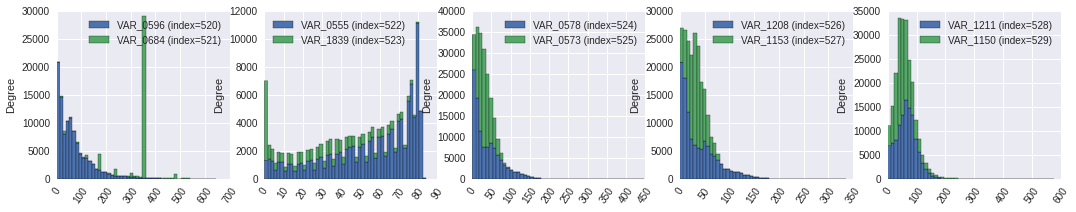

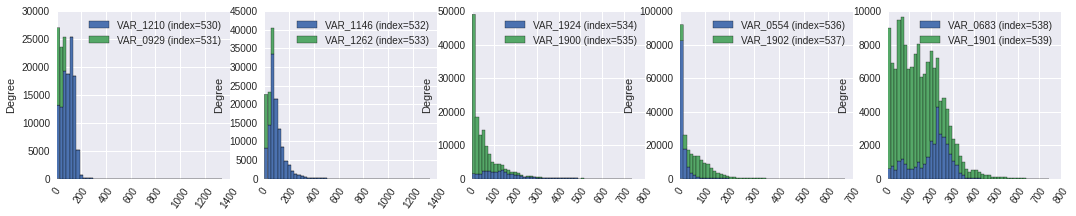

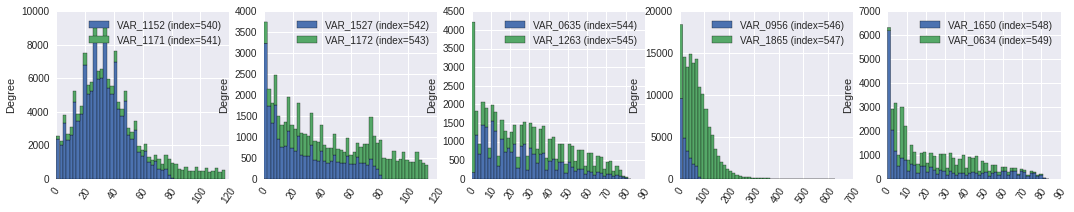

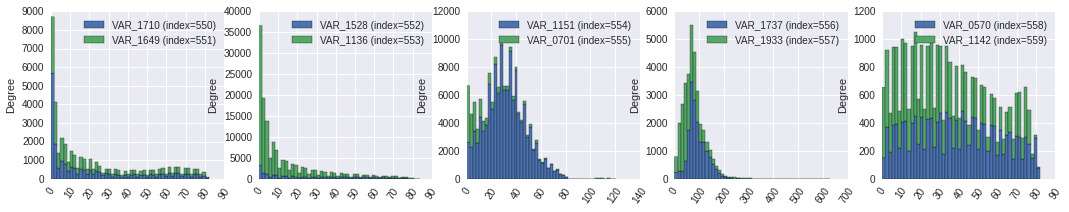

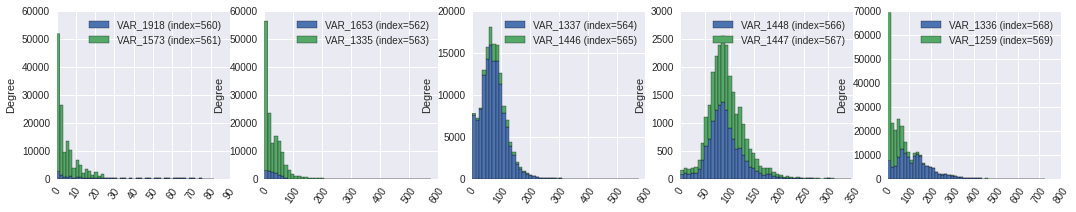

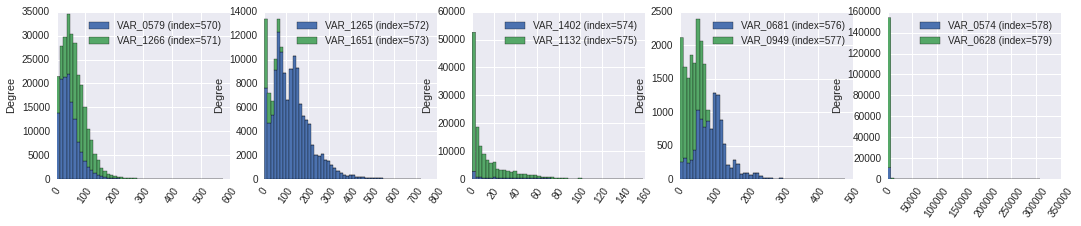

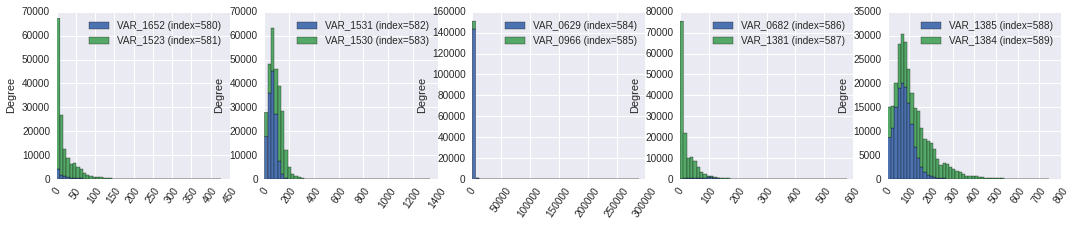

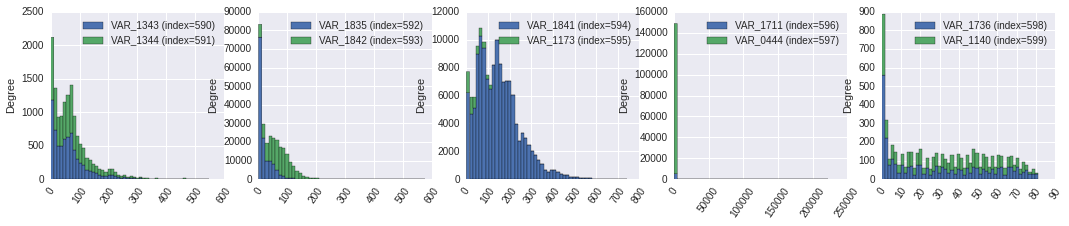

In [126]:
index = X.index[500:600]
tmp = df[index]

ex_set = set([579, 584, 597])
for i, c in enumerate(index, 500):
    if i not in ex_set:
        tmp.loc[tmp[c] > 8E3, c] = np.nan

hist_columns(tmp, X.index, 10, 2, init=500, subplots=5, legend=True, alpha=1, stacked=True, bins=50)

Looks good, let's make it permanent.

In [127]:
index = X.index[500:600]

ex_set = set([579, 584, 597])
for i, c in enumerate(index, 500):
    if i not in ex_set:
        df.loc[df[c] > 8E3, c] = np.nan


Perform the same analysis for the columns in X.index[600:700]

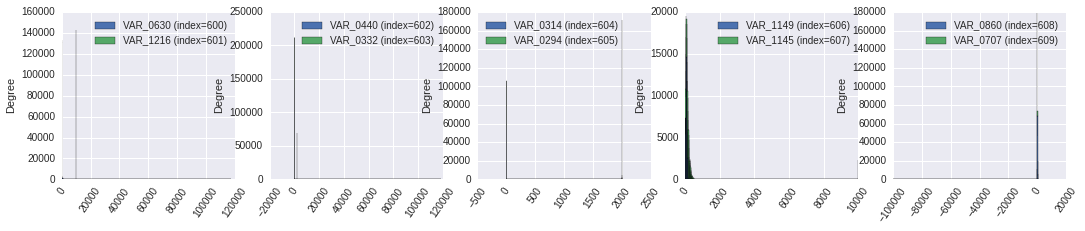

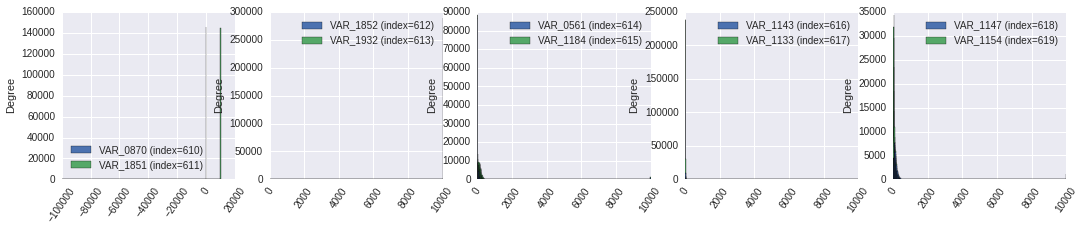

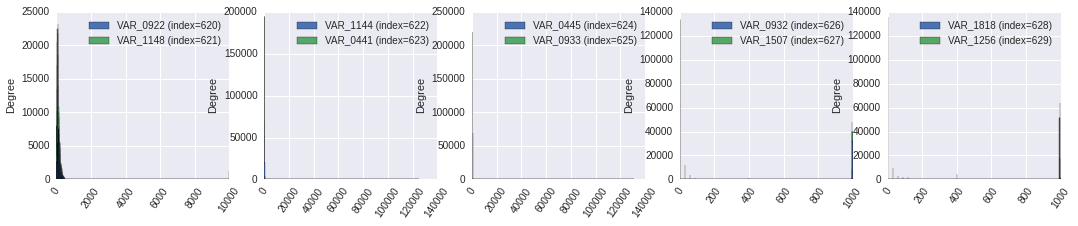

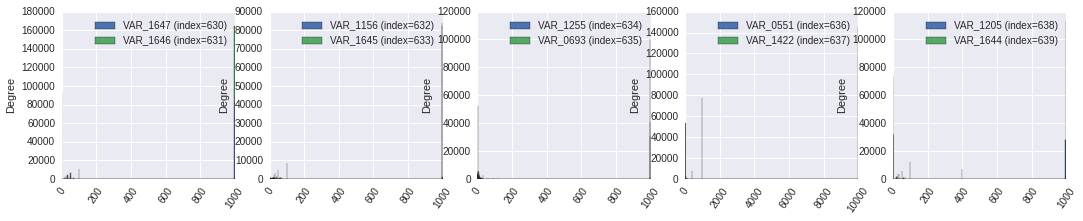

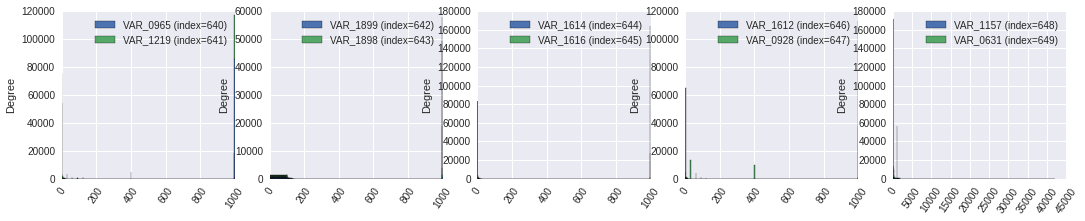

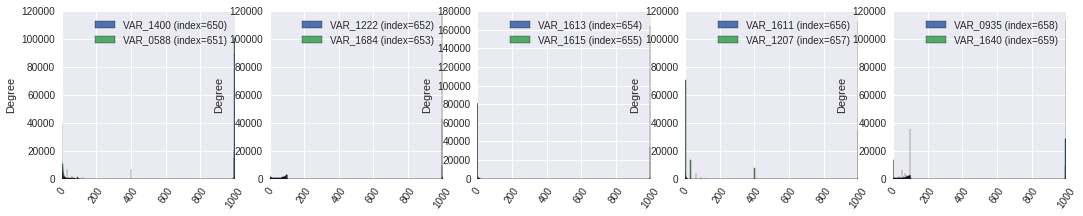

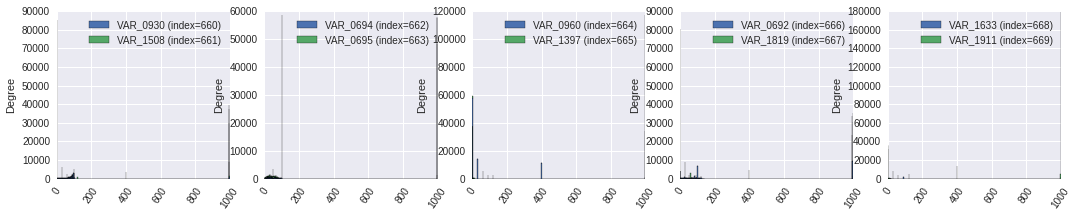

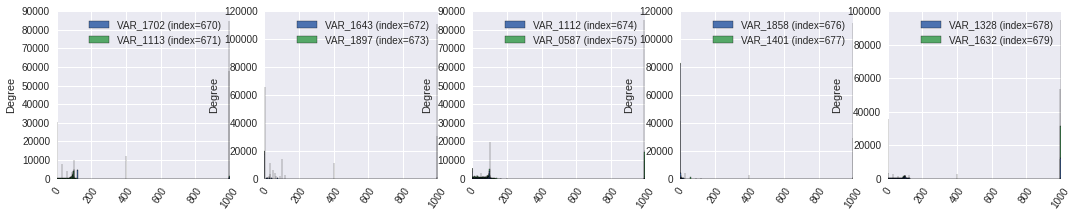

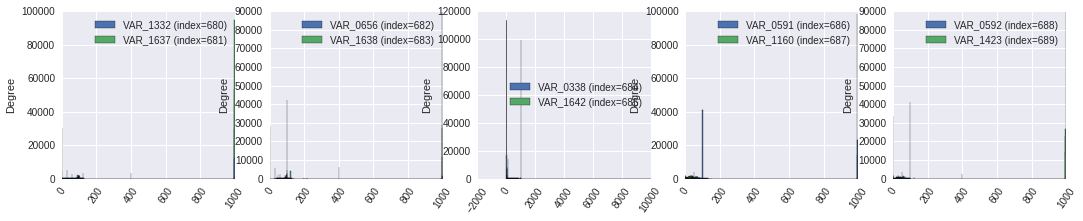

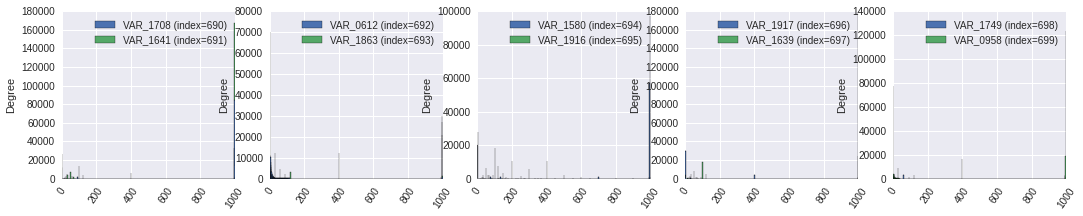

In [157]:
hist_columns(df, X.index, 10, 2, init=600, subplots=5, legend=True, alpha=1, stacked=True, bins=1000)

Replace everything above 8E3 in X.index[601:623] except 602, 604, 605, 608, 609 and 610, everything above 8E2 in X.index[625:700] except 631 and 684, everything below 0 in X.index[604, 605], and everything below -8E4 in X.index[608:611] with NaNs and plot again.

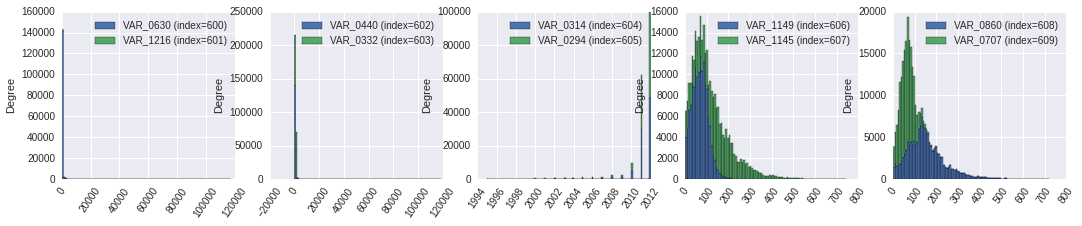

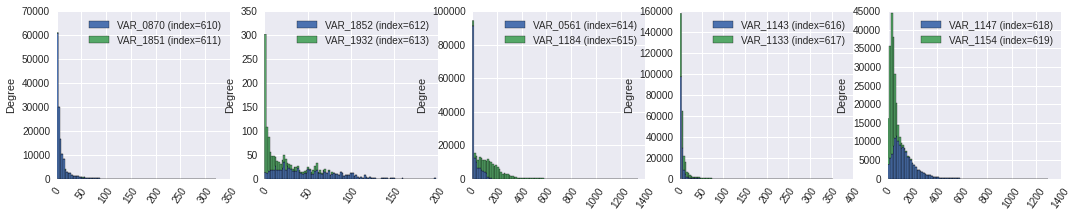

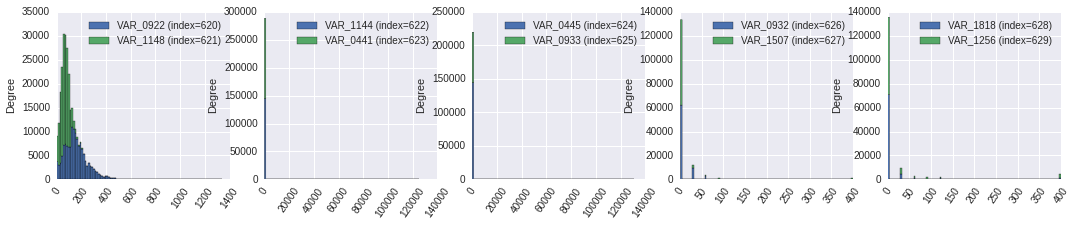

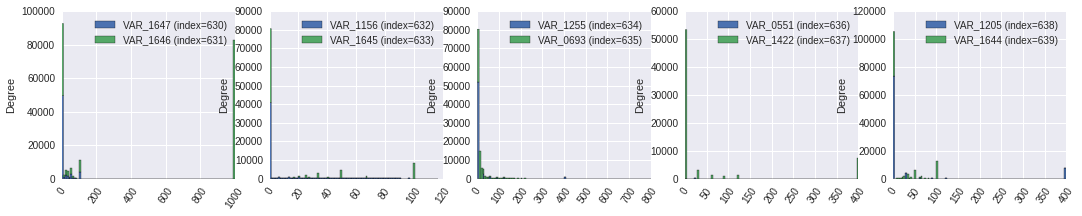

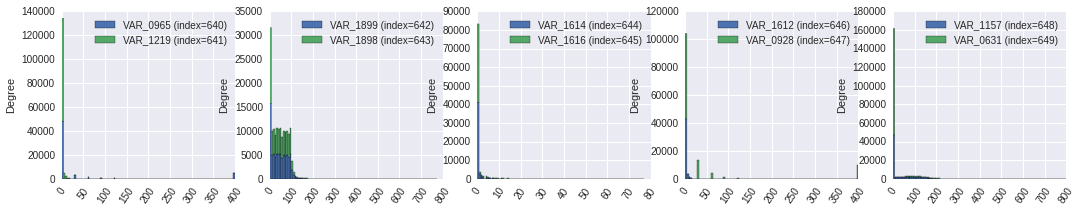

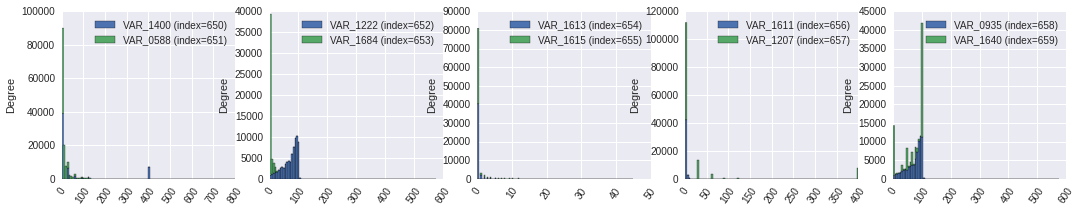

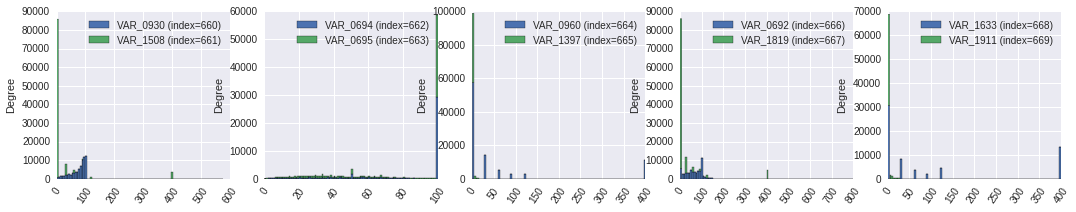

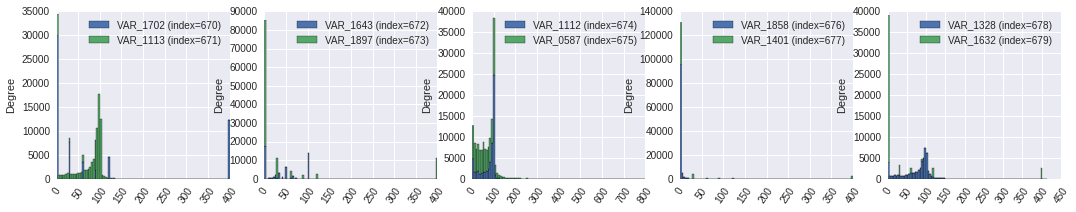

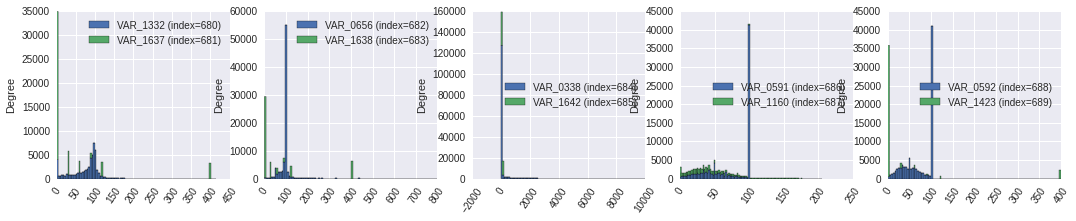

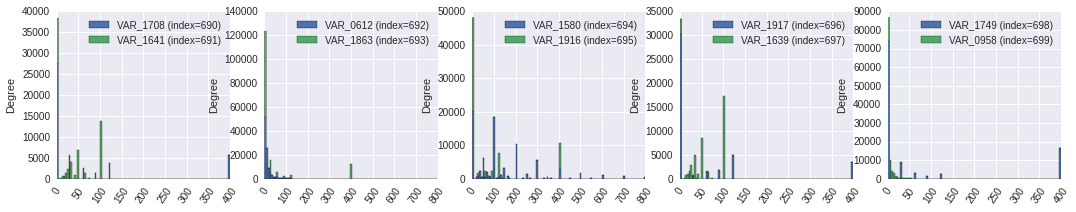

In [161]:
index = X.index[600:700]
tmp = df[index]

ex_set = set([602, 604, 605, 608, 609, 610])
for i, c in enumerate(index[1:23], 601):
    if i not in ex_set:
        tmp.loc[tmp[c] > 8E3, c] = np.nan

ex_set = set([631, 684])
for i, c in enumerate(index[25:100], 625):
    if i not in ex_set:
        tmp.loc[tmp[c] > 8E2, c] = np.nan

for c in index[[4, 5]]:
    tmp.loc[tmp[c] < 0, c] = np.nan

for c in index[8:11]:
    tmp.loc[tmp[c] < -8E4, c] = np.nan

hist_columns(tmp, X.index, 10, 2, init=600, subplots=5, legend=True, alpha=1, stacked=True, bins=100)

Looks good, let's make it permanent.

In [168]:
index = X.index[600:700]

ex_set = set([602, 604, 605, 608, 609, 610])
for i, c in enumerate(index[1:23], 601):
    if i not in ex_set:
        df.loc[df[c] > 8E3, c] = np.nan

ex_set = set([631, 684])
for i, c in enumerate(index[25:100], 625):
    if i not in ex_set:
        df.loc[df[c] > 8E2, c] = np.nan

for c in index[[4, 5]]:
    df.loc[df[c] < 0, c] = np.nan

for c in index[8:11]:
    df.loc[df[c] < -8E4, c] = np.nan


Perform the same analysis for the columns in X.index[700:800]

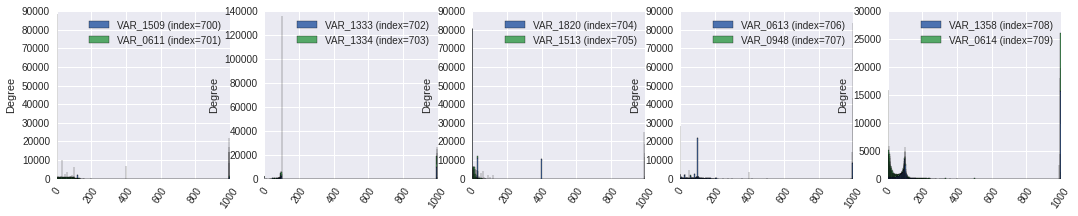

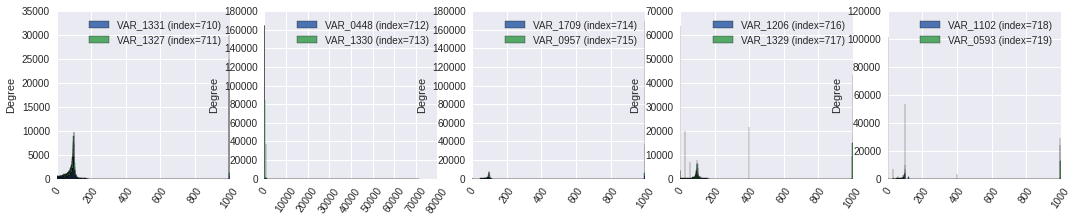

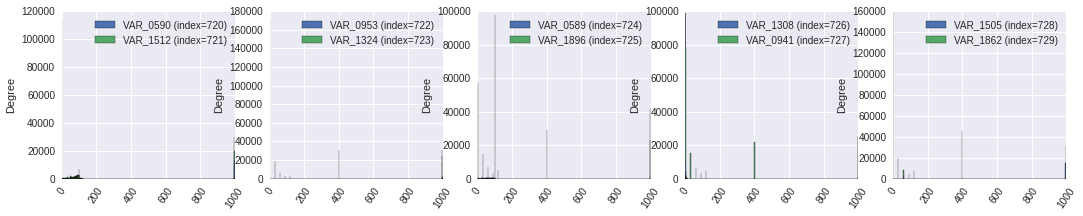

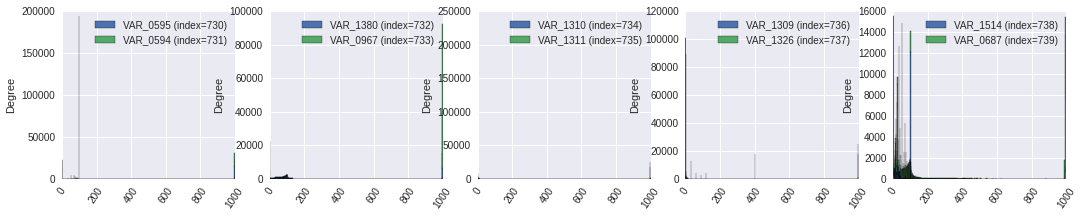

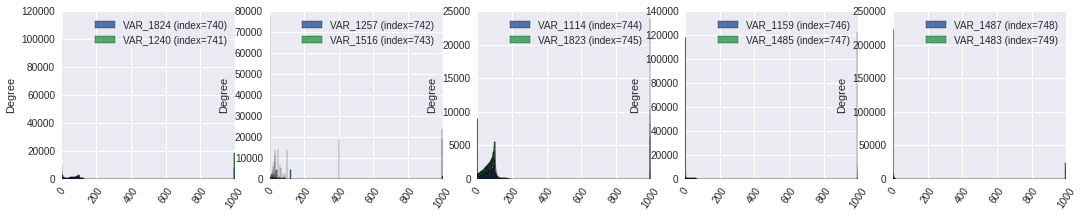

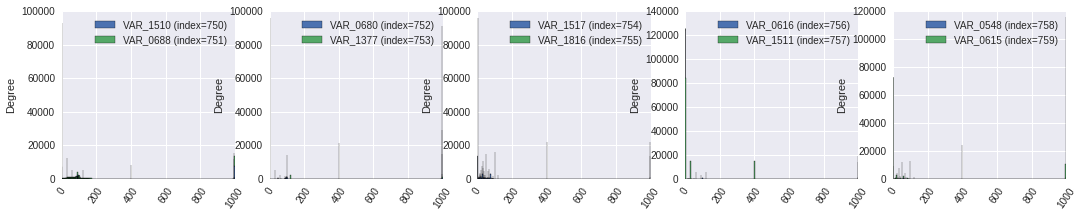

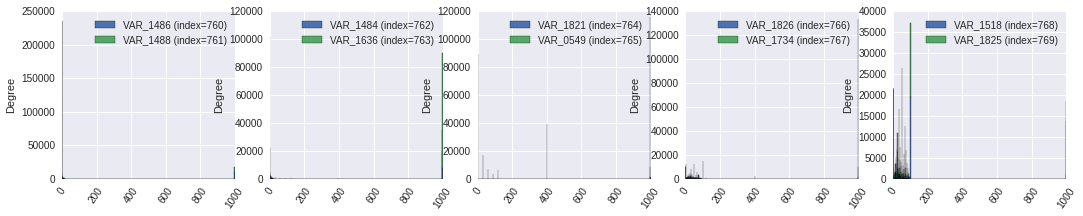

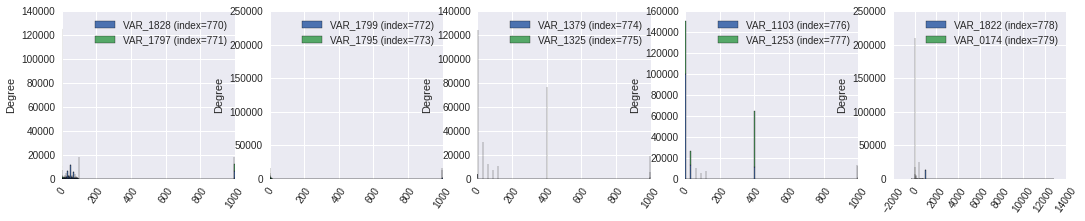

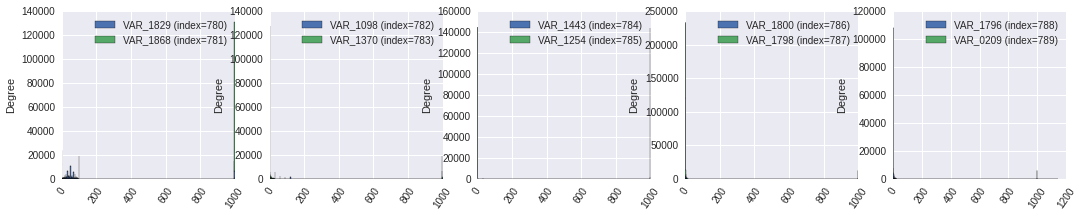

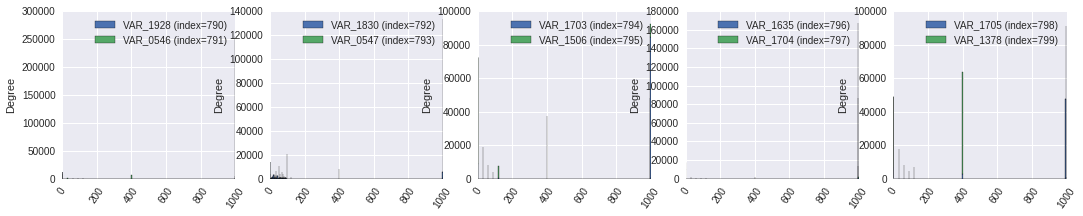

In [169]:
hist_columns(df, X.index, 10, 2, init=700, subplots=5, legend=True, alpha=1, stacked=True, bins=1000)

Replace everything above 8E2 in X.index[700:800] except 712, 779 and 789 with NaNs and plot again.

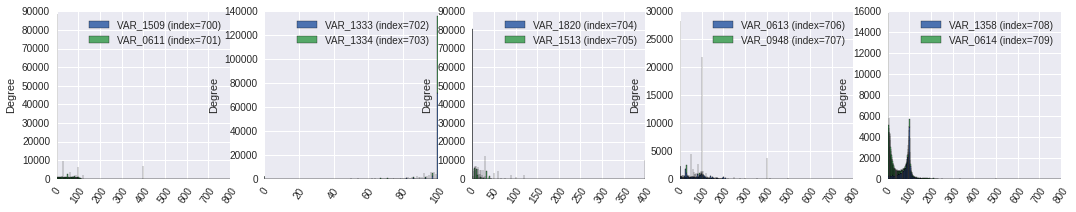

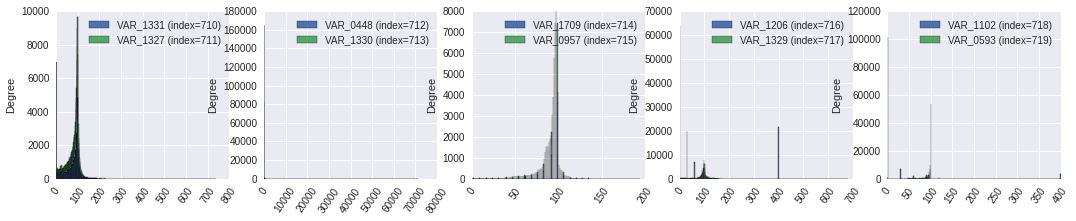

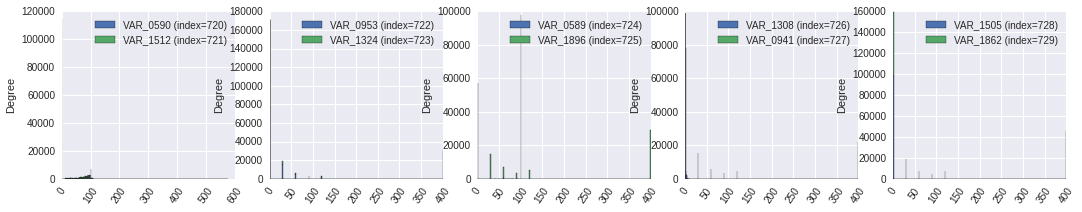

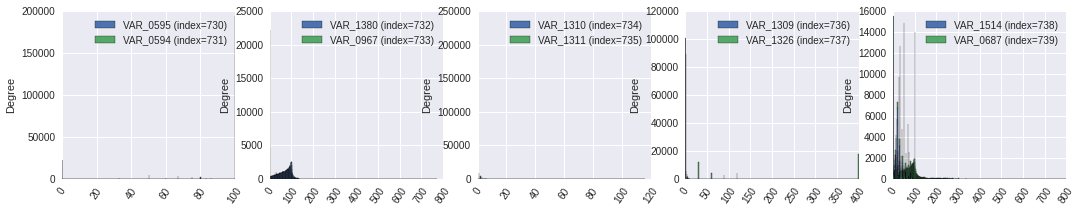

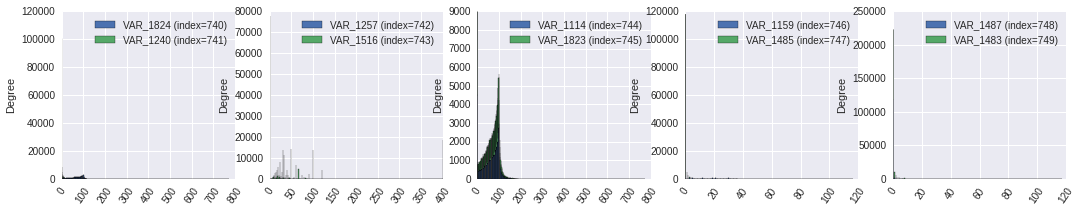

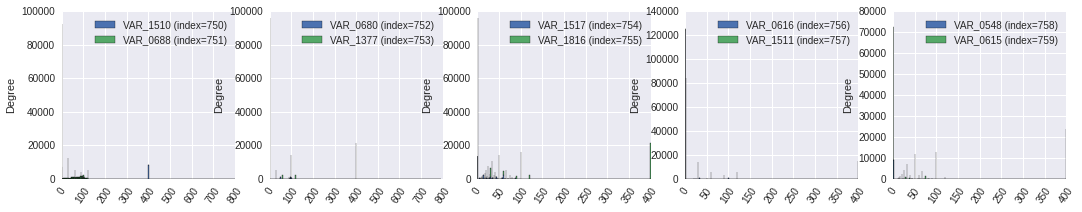

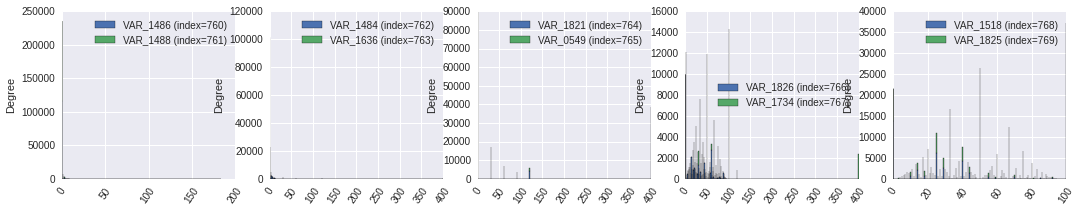

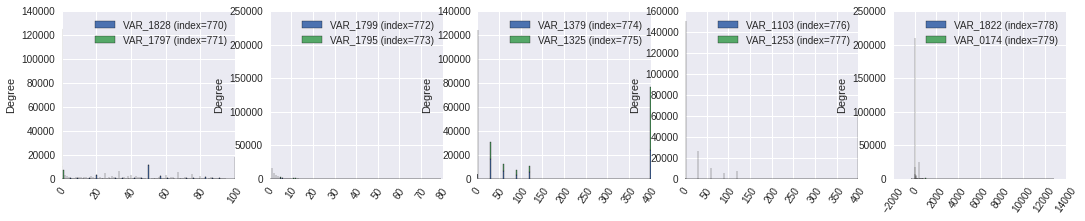

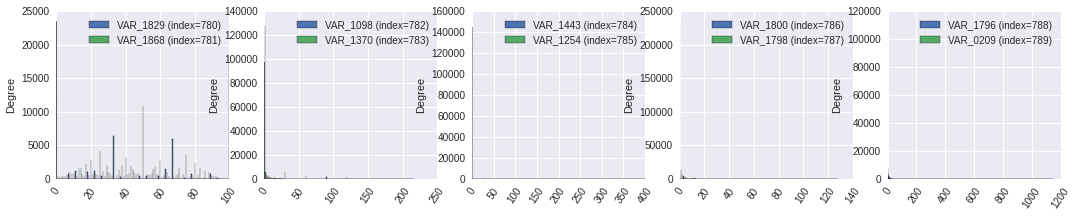

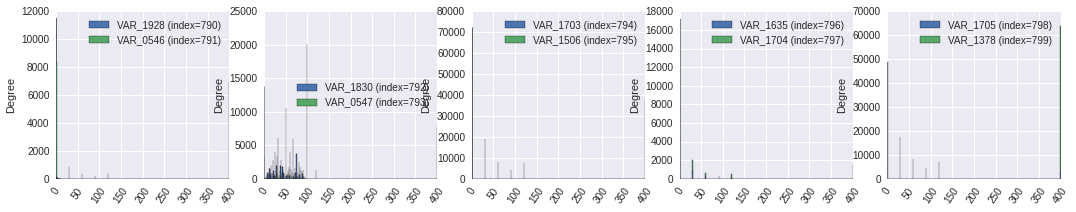

In [181]:
index = X.index[700:800]
tmp = df[index]

ex_set = set([712, 779, 789])
for i, c in enumerate(index, 700):
    if i not in ex_set:
        tmp.loc[tmp[c] > 8E2, c] = np.nan

hist_columns(tmp, X.index, 10, 2, init=700, subplots=5, legend=True, alpha=1, stacked=True, bins=1000)

Looks good, let's make it permanent.

In [5]:
index = X.index[700:800]

ex_set = set([712, 779, 789])
for i, c in enumerate(index, 700):
    if i not in ex_set:
        df.loc[df[c] > 8E2, c] = np.nan


Perform the same analysis for the columns in X.index[800:900]

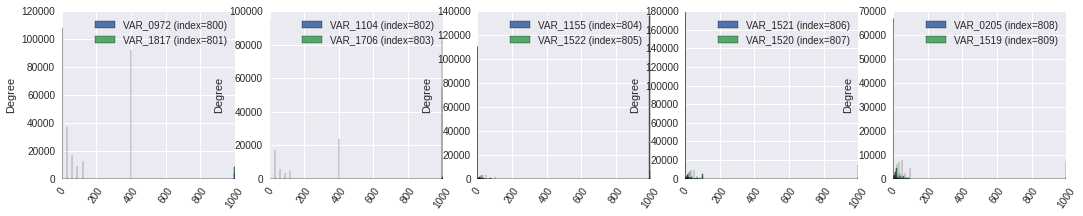

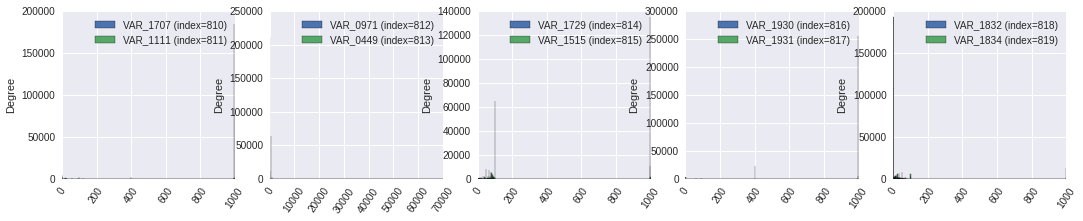

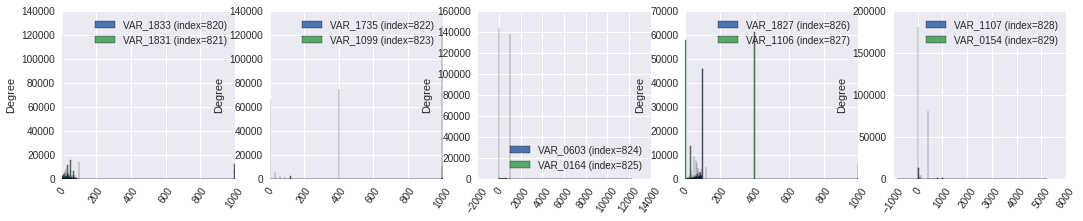

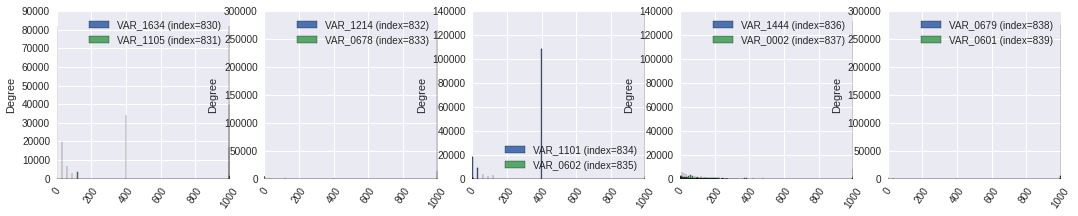

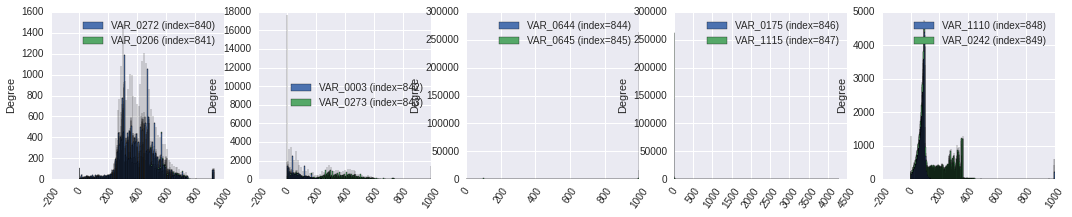

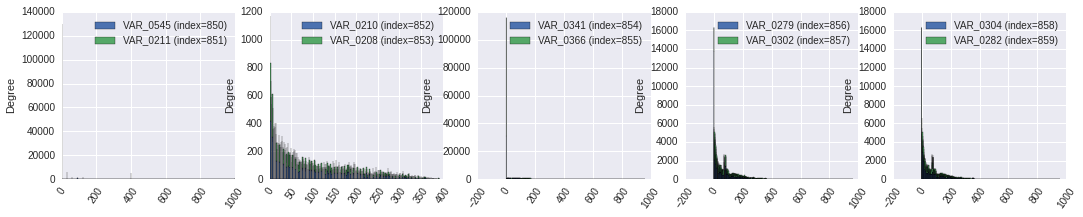

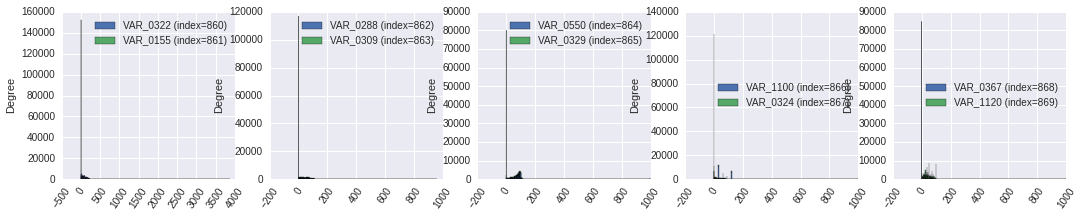

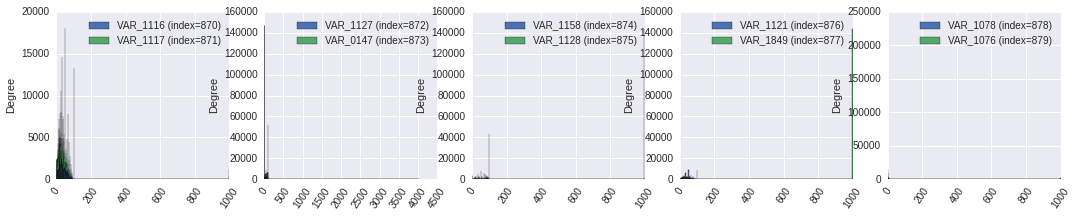

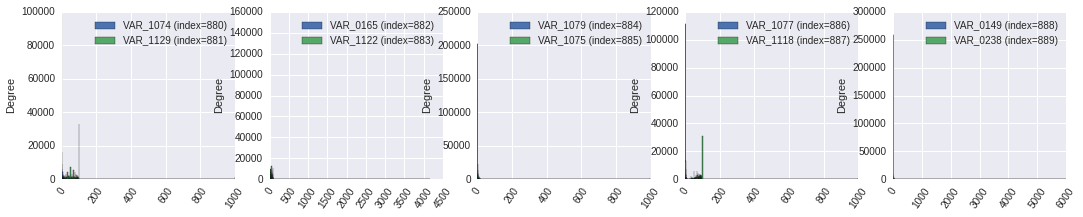

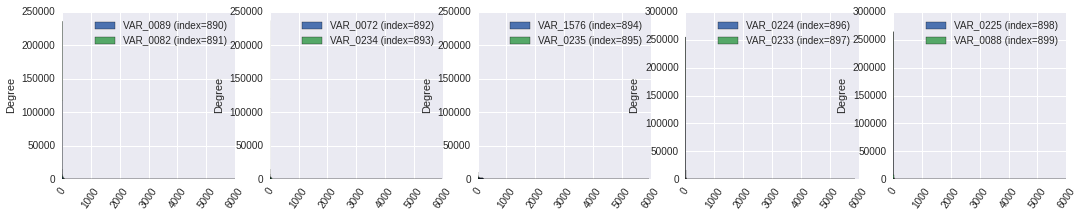

In [6]:
hist_columns(df, X.index, 10, 2, init=800, subplots=5, legend=True, alpha=1, stacked=True, bins=1000)

Replace everything above 8E2 in X.index[800:900] except 813, 825, 829, 840, 841, 851, 852, 853, 861, 873 and from 888 to 899 with NaNs and plot again.

/home/mtambos/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


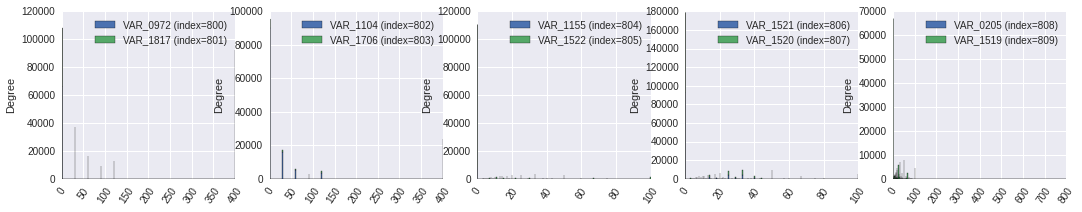

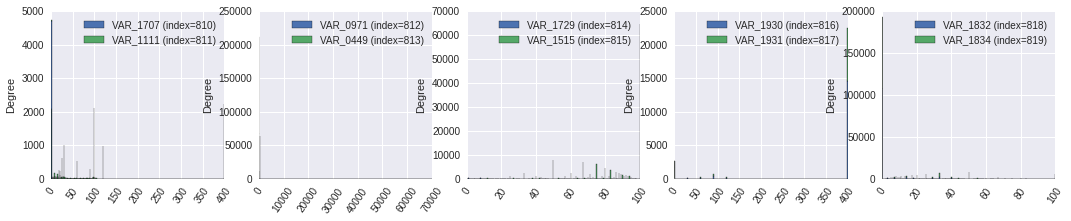

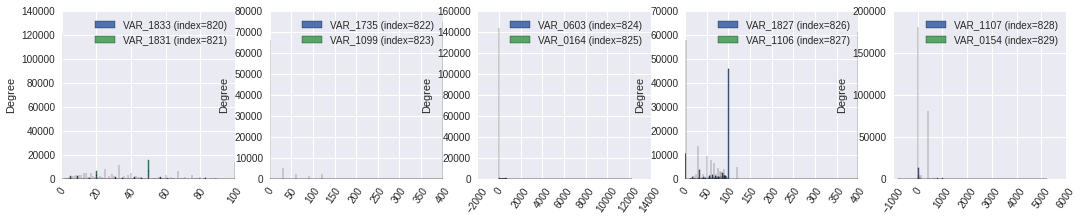

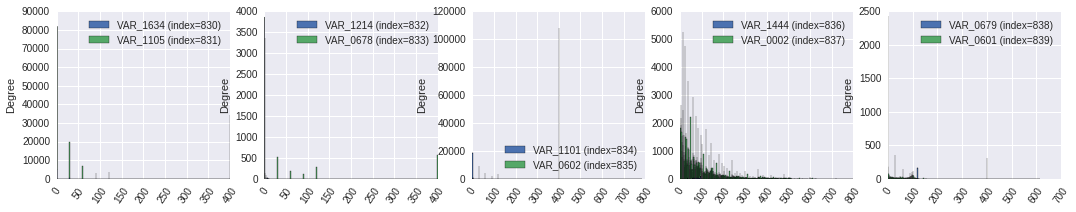

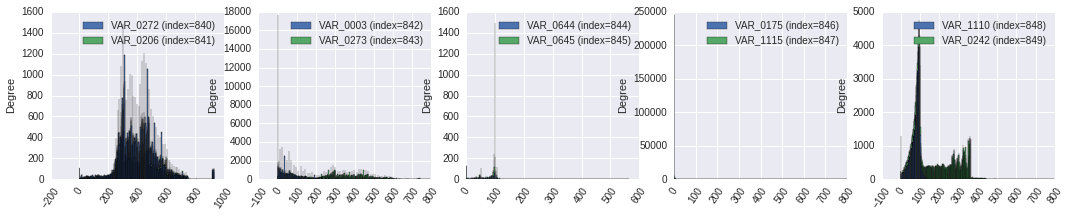

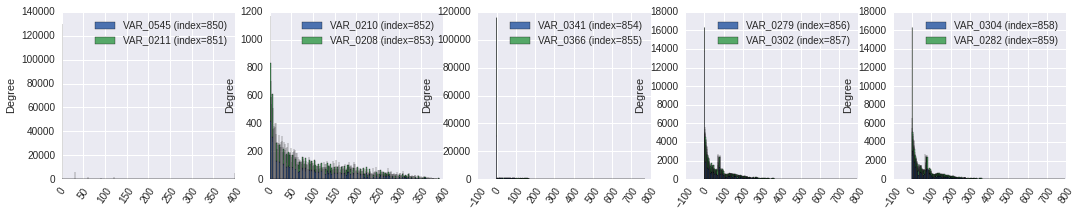

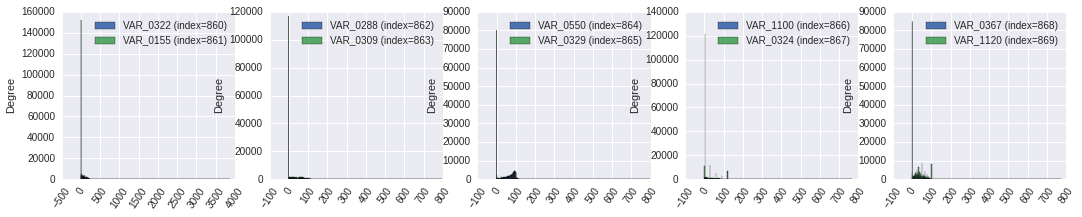

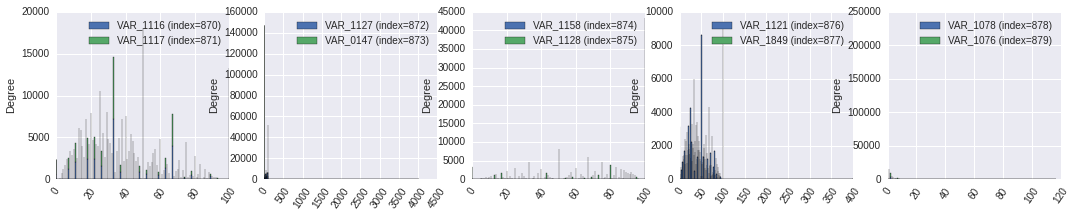

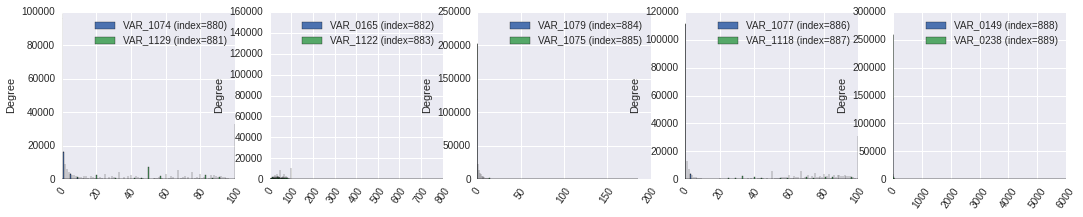

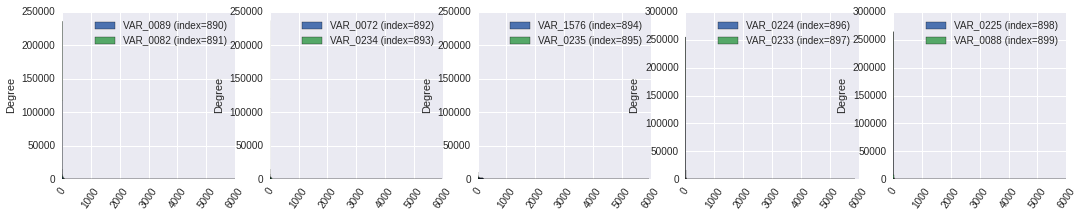

In [17]:
index = X.index[800:900]
tmp = df[index]

ex_set = set([813, 825, 829,    840, 841, 851, 852, 853, 861, 873] + range(888, 900))
for i, c in enumerate(index, 800):
    if i not in ex_set:
        tmp.loc[tmp[c] > 8E2, c] = np.nan

hist_columns(tmp, X.index, 10, 2, init=800, subplots=5, legend=True, alpha=1, stacked=True, bins=1000)

Looks good, let's make it permanent.

In [18]:
index = X.index[800:900]

ex_set = set([813, 825, 829, 840, 841, 851, 852, 853, 861, 873] + range(888, 900))
for i, c in enumerate(index, 800):
    if i not in ex_set:
        df.loc[df[c] > 8E2, c] = np.nan
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Perform the same analysis for the columns in X.index[900:1000]

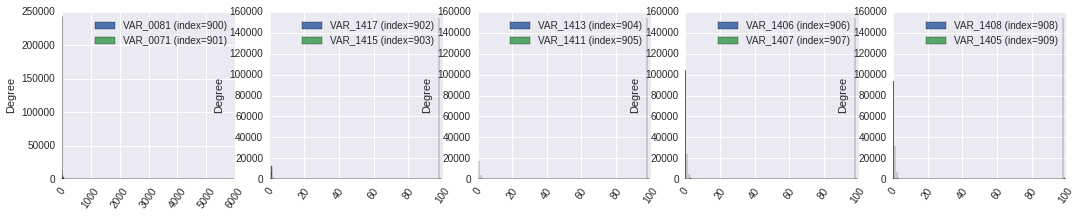

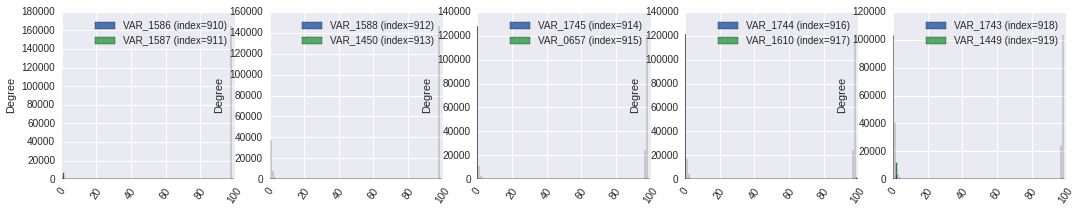

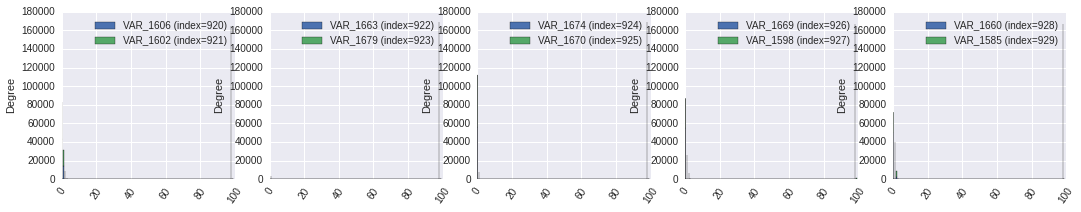

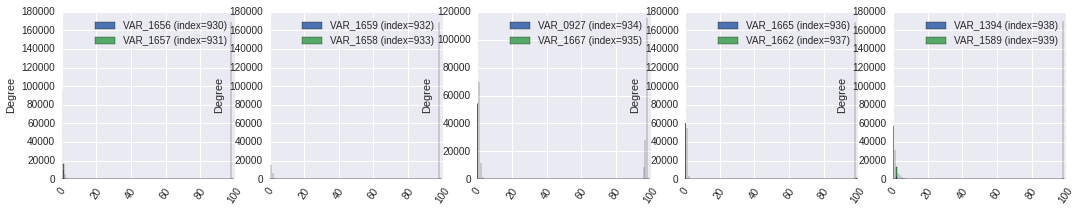

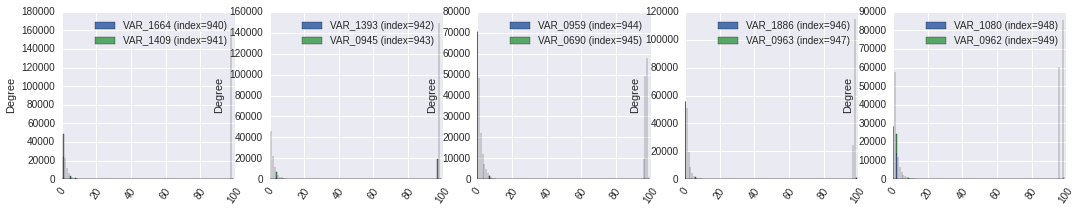

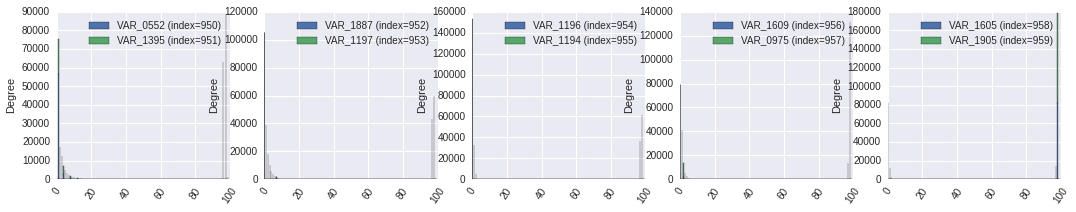

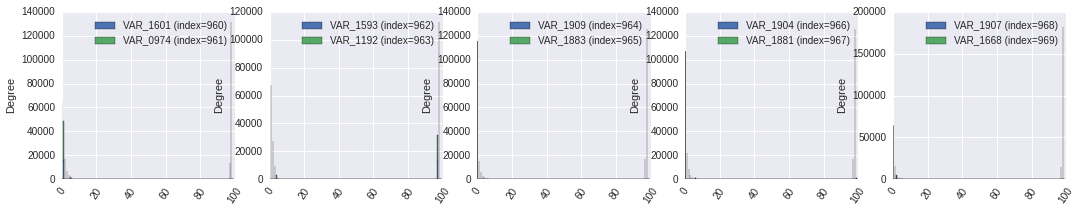

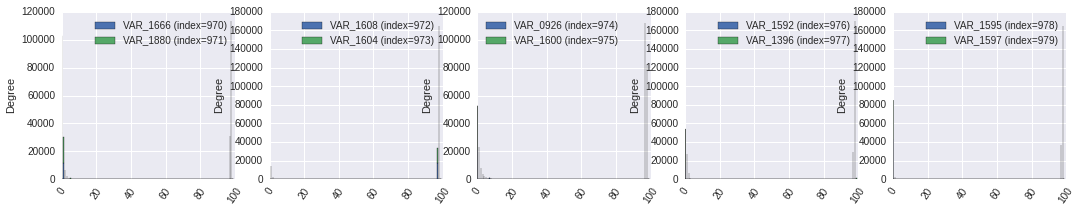

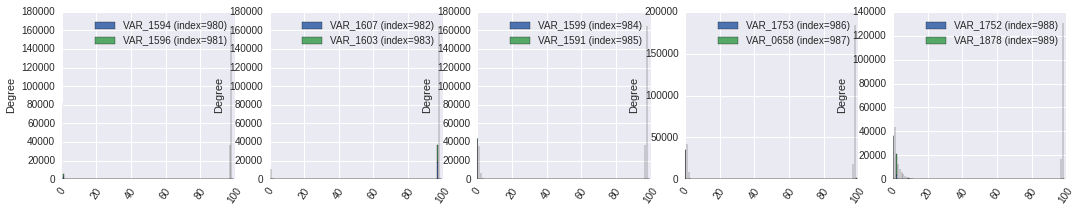

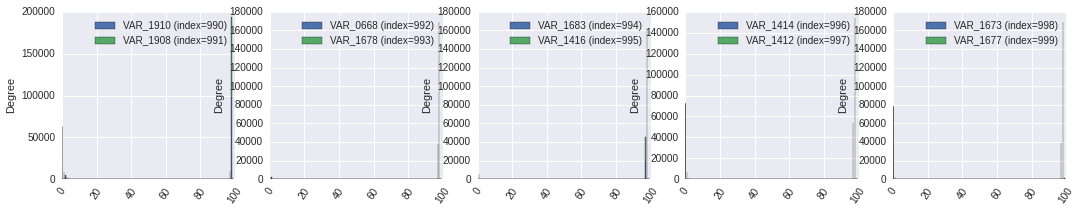

In [19]:
hist_columns(df, X.index, 10, 2, init=900, subplots=5, legend=True, alpha=1, stacked=True, bins=1000)

From here on, it seems like some 9Ex values are used as NaNs, but I think it becomes increasingly risky to eliminate them, so I stop here.

VAR_0314 and VAR_0294 seem to be years. Add them to date_cols and remove them from float_cols.

In [4]:
float_cols.remove('VAR_0314')
float_cols.remove('VAR_0294')

## Remove columns with low standard deviation
If a column has always the same value, it provides no useful information.

In [23]:
zero_std_cols = X[X == 0].index.tolist()
zero_std_cols

['VAR_0021',
 'VAR_0024',
 'VAR_0022',
 'VAR_0023',
 'VAR_0019',
 'VAR_0025',
 'VAR_0020',
 'VAR_0215',
 'VAR_0018',
 'VAR_0223',
 'VAR_0221',
 'VAR_0027',
 'VAR_0203',
 'VAR_0188',
 'VAR_0189',
 'VAR_0190',
 'VAR_0026',
 'VAR_0032',
 'VAR_0028',
 'VAR_0029',
 'VAR_0847',
 'VAR_0438',
 'VAR_0530',
 'VAR_0394',
 'VAR_0528',
 'VAR_0527',
 'VAR_0042',
 'VAR_0041',
 'VAR_0040',
 'VAR_0039',
 'VAR_0038',
 'VAR_0446',
 'VAR_0197',
 'VAR_0246',
 'VAR_1428',
 'VAR_0031',
 'VAR_0030',
 'VAR_0199']

In [25]:
df.drop(zero_std_cols, axis=1, inplace=True)
for c in zero_std_cols:
    try:
        float_cols.remove(c)
    except:
        print c

ValueError: labels ['VAR_0021' 'VAR_0024' 'VAR_0022' 'VAR_0023' 'VAR_0019' 'VAR_0025'
 'VAR_0020' 'VAR_0215' 'VAR_0018' 'VAR_0223' 'VAR_0221' 'VAR_0027'
 'VAR_0203' 'VAR_0188' 'VAR_0189' 'VAR_0190' 'VAR_0026' 'VAR_0032'
 'VAR_0028' 'VAR_0029' 'VAR_0847' 'VAR_0438' 'VAR_0530' 'VAR_0394'
 'VAR_0528' 'VAR_0527' 'VAR_0042' 'VAR_0041' 'VAR_0040' 'VAR_0039'
 'VAR_0038' 'VAR_0446' 'VAR_0197' 'VAR_0246' 'VAR_1428' 'VAR_0031'
 'VAR_0030' 'VAR_0199'] not contained in axis

In [6]:
#low_std_cols = X[X < 0.01].index.tolist()
#df.drop(low_std_cols, axis=1, inplace=True)
#for c in low_std_cols:
#    float_cols.remove(c)

# Drop duplicated rows and columns

###  Drop duplicate rows

In [4]:
print len(df)
df.drop_duplicates(inplace=True)
print len(df)

145231
145231


### Drop duplicate columns

In [5]:
cols = {i: df.columns[i] for i in range(df.columns.size)}

In [6]:
cols_to_drop = set()
for i in range(len(cols) - 1):
    c1 = cols[i]
    print "Checking duplicates of column " + c1
    for j in range(i+1, len(cols)):
        c2 = cols[j]
        if (c2 not in cols_to_drop) and (df[c1] == df[c2]).all():
            cols_to_drop.add(c2)
    print "Duplicates found: " + str(cols_to_drop)

Checking duplicates of column VAR_0001
Duplicates found: set([])
Checking duplicates of column VAR_0002
Duplicates found: set([])
Checking duplicates of column VAR_0003
Duplicates found: set([])
Checking duplicates of column VAR_0004
Duplicates found: set([])
Checking duplicates of column VAR_0005
Duplicates found: set([])
Checking duplicates of column VAR_0006
Duplicates found: set([])
Checking duplicates of column VAR_0007
Duplicates found: set([])
Checking duplicates of column VAR_0008
Duplicates found: set([])
Checking duplicates of column VAR_0009
Duplicates found: set([])
Checking duplicates of column VAR_0010
Duplicates found: set([])
Checking duplicates of column VAR_0011
Duplicates found: set([])
Checking duplicates of column VAR_0012
Duplicates found: set([])
Checking duplicates of column VAR_0013
Duplicates found: set([])
Checking duplicates of column VAR_0014
Duplicates found: set([])
Checking duplicates of column VAR_0015
Duplicates found: set([])
Checking duplicates of co

In [7]:
df = df.drop(cols_to_drop, axis=1)

## Impute missing float values

In [16]:
df[float_cols] = df[float_cols].astype(np.float32)

In [17]:
col_medians = df[float_cols].median(skipna=True)
assert len(col_medians) == len(float_cols) 
df[float_cols] = df[float_cols].fillna(value=col_medians)
df[float_cols]

VAR_0002  VAR_0003  VAR_0006  VAR_0007  VAR_0013  VAR_0014  VAR_0015  \
ID                                                                             
2            224         0         0         0         0         0         0   
4              7        53         1         0         1         0         1   
5            116         3         0         0         0         0         0   
7            240       300         0         0         0         0         0   
8             72       261         0         0         0         0         0   
14             4         4         0         0         0         0         0   
16            60       132         1         1         1         1         1   
20            13        75         0         0         0         0         0   
21            17        16         1         1         1         1         1   
22            24        72         0         0         0         0         0   
23            61        12         1         1         1         1         1   
24           140         0         0         0         0         0         0   
25           258        14         6         2         6         1         4   
26            43       126         0         0         0         0         0   
28            36        99         0         0         0         0         0   
30             6        24         0         0         0         0         0   
31           252         2         0         0         0         0         0   
32            13        69         0         0         0         0         0   
35            28        52         2         1         2         1         2   
36             4       124         0         0         0         0         0   
37            17        24         0         0         0         0         0   
38           137       228         0         0         0         0         0   
40           120       157         0         0         0         0         0   
42            24        24         0         0         0         0         0   
43             2        48         0         0         0         0         0   
46             3         5         0         0         0         0         0   
50           128       128         0         0         0         0         0   
51            24       151         1         1         1         1         1   
52            49        30         3         2         3         2         4   
54             2         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
290409        65        29         0         0         0         0         0   
290412       132        54         0         0         0         0         0   
290414        17        89         2         1         2         1         3   
290415       188        32         0         0         0         0         0   
290417       312        60         0         0         0         0         0   
290424       204       156         0         0         0         0         0   
290426        14        73         0         0         0         0         0   
290427       323       151         0         0         0         0         0   
290429        13       117         6         2         6         2         2   
290431         8         8         0         0         0         0         0   
290432        60       120         0         0         0         0         0   
290434        65       137         0         0         0         0         0   
290436         6         0         1         1         1         1         1   
290439        40        68         0         0         0         0         0   
290440        71        95         0         0         0         0         0   
290441        30       108         2         1         2         1         1   
290443        68       133         0         0         0         0         0   
290445  

### Remove columns with only NaNs

In [20]:
nan_cols = df[float_cols].isnull().all()
nan_cols = nan_cols.index[nan_cols].tolist()
nan_cols

['VAR_0207', 'VAR_0213', 'VAR_0840']

In [21]:
df.drop(nan_cols, axis=1, inplace=True)
for c in nan_cols:
    float_cols.remove(c)

# Save preprocessed data to another csv file

In [55]:
PTRAIN_PATH

'/media/mtambos/speedy/train_preprocessed_float.csv'

In [22]:
df.to_csv(PTRAIN_PATH)

In [21]:
with open('X.pickle', 'wb') as fp:
    pickle.dump(X, fp)

In [19]:
with open('float_medians.pickle', 'wb') as fp:
    pickle.dump(col_medians, fp)